In [1]:
# =====================================================================
# Imports
# =====================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime
from decimal import Decimal, ROUND_HALF_UP, InvalidOperation
import xlrd


In [2]:
# =====================================================================
# Load Shiller Data
# =====================================================================
# Load Shiller data from local Excel file
def load_shiller_data(path="ie_data.xls", start_year=1926):
    """
    Load Shiller data and compute NOMINAL stock & bond returns, plus YoY inflation.
    - Stock = (P + D) / P(-1) - 1  (nominal total return)
    - Bond  = BondIndex.pct_change() (nominal bond return)
    - Inflation = YoY CPI % change
    """

    # --- Parse YYYY.MM robustly ---
    def parse_yyyymm(val):
        """
        Convert Shiller's date format (e.g., 2024.10) into a proper pandas Timestamp.
        Excel sometimes stores 2024.10 as 2024.1 (dropping the zero).
        This function forces two decimals using Decimal quantization.

        Steps:
        - Convert the value into a Decimal with two decimal places.
        - Split into year (integer part) and month (fractional part * 100).
        - Return a Timestamp with the 1st day of that month if valid.
        - Return NaT (Not-a-Time) if parsing fails or month is invalid.
        """
        try:
            d = Decimal(str(val)).quantize(Decimal("0.00"), rounding=ROUND_HALF_UP)
        except InvalidOperation:
            return pd.NaT  # if conversion fails, return missing date
        year = int(d)                     # integer part = year
        month = int((d - year) * 100)     # fractional part × 100 = month
        return pd.Timestamp(year, month, 1) if 1 <= month <= 12 else pd.NaT

    # --- Read Excel ---
    # Load Shiller Excel file from "Data" sheet, skipping metadata rows.
    # skiprows=7: skip top 7 rows of metadata/headers
    # skipfooter=1: drop the last row (often footnote)
    df_raw = pd.read_excel(path, sheet_name="Data", skiprows=7, skipfooter=1)

    # Select only the needed columns (by column index):
    #   0 = Date, 1 = Price, 2 = Dividend, 4 = CPI, 17 = Bond Index
    df = df_raw.iloc[:, [0, 1, 2, 4, 17]].copy()
    df.columns = ["Date", "Price", "Dividend", "CPI", "BondIndex"]

    # --- Fix dates ---
    # Apply the custom date parser to ensure correct YYYY.MM format
    df["Date"] = df["Date"].apply(parse_yyyymm)
    # Drop rows with invalid dates, sort chronologically, and set Date as index
    df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

    # --- Compute returns ---
    # Stock returns (nominal total return):
    #   Formula = (Price change + monthly dividend) / Previous price
    #   Dividends are annual in Shiller’s dataset, so divide by 12 to get monthly.
    df["Stock"] = (df["Price"] - df["Price"].shift(1) + df["Dividend"] / 12) / df["Price"].shift(1)

    # Bond returns:
    #   BondIndex is already a return index, so subtract 1 to get monthly return.
    df["Bond"] = df["BondIndex"] - 1

    # Inflation:
    #   Year-over-year percentage change in CPI (12-month lag).
    df["Inflation"] = df["CPI"].pct_change(12)

    # --- Trim to desired start year ---
    # Keep only rows at or after the chosen start_year (default = 1926).
    df = df[df.index.year >= start_year]

    # Return only the computed columns of interest
    return df[["Stock", "Bond", "Inflation"]]


In [3]:
# =====================================================================
# Explore Shiller Data
# =====================================================================

# Load the Shiller dataset using the custom loader defined earlier.
# Default path = "ie_data.xls", default start year = 1926
data = load_shiller_data()

# --- Quick statistics ---

# Print the mean stock return (annualized).
# data["Stock"].mean() gives the average monthly return.
# Multiply by 12 to convert from monthly average to approximate annual return.
print("Mean stock return (annualized):", data["Stock"].mean() * 12)

# Print the mean bond return (annualized).
# Same approach: monthly average return × 12 = approximate annualized return.
print("Mean bond return (annualized):", data["Bond"].mean() * 12)

# Print the mean inflation rate.
# Inflation is already calculated as a year-over-year % change, so no scaling needed.
print("Mean inflation:", data["Inflation"].mean())

# Display the first 5 rows of the dataset for a quick sanity check.
# This shows the computed Stock, Bond, and Inflation columns aligned with dates.
print(data.head())


Mean stock return (annualized): 0.11060291938286437
Mean bond return (annualized): 0.04819637699930383
Mean inflation: 0.030283829645595298
               Stock      Bond  Inflation
Date                                     
1926-01-01  0.019312  0.005421   0.034682
1926-02-01  0.005632  0.005400   0.040698
1926-03-01 -0.063783  0.005380   0.028902
1926-04-01 -0.023497  0.005359   0.040698
1926-05-01  0.011596  0.005339   0.028902


In [4]:
# Annualize geometric returns
def annualize_geometric(r):
    """
    Annualize a series of monthly returns using geometric compounding.
    - Unlike the arithmetic mean (simple average), this accounts for compounding.
    - Formula:
        Geometric Annual Return = (Π(1 + r_monthly))^(12 / N) - 1
        where N = number of months in the series.
    """
    # Drop missing values to avoid NaNs interfering with the calculation
    r = r.dropna()

    # Step 1: Compute total compounded growth over the whole period
    # Example: if returns = [0.01, -0.02, 0.03],
    # total_growth = (1.01 × 0.98 × 1.03)
    total_growth = (1 + r).prod()

    # Step 2: Scale the compounded growth to an annual rate
    # Raise total_growth to the power of (12 / number_of_months)
    #   → adjusts monthly compounding to yearly frequency
    # Subtract 1 to convert back into a return percentage
    return total_growth**(12/len(r)) - 1


# --- Load Shiller data (default: start_year=1926) ---
data = load_shiller_data()

# --- Compute geometric annualized returns ---
# For stocks: uses total return (Price + Dividends)
stock_geom = annualize_geometric(data["Stock"])

# For bonds: uses BondIndex returns
bond_geom  = annualize_geometric(data["Bond"])

# --- Display results ---
print("Geometric stock return (annualized):", stock_geom)
print("Geometric bond return (annualized):", bond_geom)

# Inflation is already YoY change in CPI, so the mean is directly interpretable
print("Mean inflation (YoY):", data["Inflation"].mean())


Geometric stock return (annualized): 0.10351727245586706
Geometric bond return (annualized): 0.047707196709787514
Mean inflation (YoY): 0.030283829645595298


In [5]:
# =====================================================================
# Inflation Regimes & Markov Transitions (with custom matrix)
# =====================================================================

def label_regime(infl):
    """Classify inflation into low (<3%), mid (3-5%), or high (≥5%)."""
    # Compare the monthly YoY inflation reading to fixed thresholds:
    #   - < 3%  → "low"
    #   - 3–5%  → "mid"
    #   - ≥ 5%  → "high"
    if infl < 0.03: return "low"
    if infl < 0.05: return "mid"
    return "high"

# Label each month in history
# Apply the classifier across the Inflation series to get a categorical regime per month.
data["Regime"] = data["Inflation"].apply(label_regime)

# Define all regimes
# An explicit ordered list of all possible regime labels (useful for validation/iteration).
ALL_REGIMES = ["low", "mid", "high"]

# --- Stylized transition matrix (P[next | current]) ---
# A Markov transition matrix specified as nested dicts:
#   transition_matrix[current_regime][next_regime] = probability
# Rows (current regime) sum to ~1.0. Diagonal terms control persistence.
# Higher diagonal → regime tends to continue; lower diagonal → more switching.
transition_matrix = {
    "low":   {"low": 0.85, "mid": 0.10, "high": 0.05},
    "mid":   {"low": 0.10, "mid": 0.80, "high": 0.10},
    "high":  {"low": 0.05, "mid": 0.10, "high": 0.85},
}

def sample_next_regime(current_regime, rng=np.random):
    """
    Sample the next inflation regime using the custom transition matrix.

    Parameters
    ----------
    current_regime : str
        One of {"low", "mid", "high"} representing the current state.
    rng : numpy.random module or Generator-like (optional)
        Random number source; defaults to numpy's global RNG.

    Returns
    -------
    str
        The next regime drawn according to P(next | current).
    """
    # Look up the row of transition probabilities for the current regime.
    transitions = transition_matrix.get(current_regime)
    if transitions is None:
        # Defensive check: raise if an unexpected label is encountered.
        raise ValueError(f"Unknown regime: {current_regime}")
    
    # Extract ordered lists of next-state labels and their probabilities.
    regimes = list(transitions.keys())
    probs   = list(transitions.values())

    # Draw one sample from the categorical distribution defined by probs.
    return rng.choice(regimes, p=probs)

def infer_starting_regime(current_year):
    """
    Infer starting regime from the most recent inflation observation in
    current_year (or fall back to latest data if unavailable).

    Logic
    -----
    1) Try to slice the historical data to the specified year.
    2) If that slice exists and is non-empty, take the latest inflation
       observation from that year and map it to a regime.
    3) If the year has no data (e.g., current year beyond dataset), fall
       back to the last available inflation reading in the dataset.
    """
    try:
        # Slice rows whose DatetimeIndex year equals current_year.
        year_slice = data.loc[str(current_year)]
        if len(year_slice) > 0:
            # Use the most recent monthly observation within that year.
            infl0 = year_slice["Inflation"].iloc[-1]
            return label_regime(infl0)
    except KeyError:
        # If .loc[str(year)] fails (no rows for that year), ignore and fall back.
        pass

    # Fallback: use the most recent inflation observation in the entire dataset.
    infl_last = data["Inflation"].iloc[-1]
    return label_regime(infl_last)


In [6]:
# =====================================================================
# Global Cache Bootstraps
# =====================================================================
# These caches are used across simulation, success-rate estimation,
# and regime-statistics to avoid recomputing results in Monte Carlo runs.

# ---- Success-rate cache ----
try:
    _SUCCESS_CACHE
except NameError:
    _SUCCESS_CACHE = {}                 # {(expense:int, trials:int, threshold:float): success_rate_float}
try:
    _SUCCESS_CACHE_FINGERPRINT
except NameError:
    _SUCCESS_CACHE_FINGERPRINT = None   # fingerprint of current model settings
try:
    _SR_AGG
except NameError:
    _SR_AGG = {}                        # {(expense:int, threshold:float): [trials_done:int, successes:int]}

# ---- Regime-statistics cache ----
try:
    _REGIME_STAT_CACHE
except NameError:
    _REGIME_STAT_CACHE = {}             # {(regime, half_life, use_corr, retdist, stock_df, bond_df): 
                                        #   (mean_a, cov_a, infl_pool, infl_w)}


In [7]:
# =====================================================================
# Parameters
# =====================================================================
params = {
    # ----------------------------
    # Account balances (starting)
    # ----------------------------
    "taxable_init": 200_000,            # Starting balance in taxable brokerage account
    "taxable_basis_fraction": 0.75,     # Fraction of taxable balance that is cost basis (for cap gains calc)
    "td_A_init": 500_000,               # Tax-deferred balance for spouse A (e.g., Traditional IRA/401k)
    "td_B_init": 350_000,               # Tax-deferred balance for spouse B
    "roth_init": 150_000,               # Roth balance (qualified withdrawals are typically tax-free)

    # -------------
    # Household
    # -------------
    "filing_status": "married",         # Filing status impacts tax brackets/standard deduction
    "spouse_A_start_age": 65,           # Current or starting age for spouse A
    "spouse_B_start_age": 60,           # Current or starting age for spouse B
    "life_expectancy_A": 95,            # Planning horizon age for spouse A (used if use_mortality=False or as cap)
    "life_expectancy_B": 95,            # Planning horizon age for spouse B
    "survivor_expense_percent": 0.75,   # % of household expenses that persist for survivor after first death

    # -----
    # Taxes
    # -----
    "ordinary_tax_rate": 0.20,          # Flat ordinary income tax rate used in the model (simplification)
    "cap_gains_tax_rate": 0.15,         # Flat long-term capital gains/dividends tax rate (simplification)

    # -------------------
    # Spending & COLA
    # -------------------
    "initial_expense": 80_000,          # Year-1 spending target before COLA adjustments
    "expense_cola": 0.025,              # Annual cost-of-living adjustment applied to expenses
    "ss_cola": 0.025,                   # Annual COLA applied to Social Security benefits

    # ----------------
    # Social Security
    # ----------------
    "ss_A": {"start_age": 67, "amount": 25_000},  # Spouse A: claim age & first-year annual benefit (pre-COLA)
    "ss_B": {"start_age": 67, "amount": 15_000},  # Spouse B: claim age & first-year annual benefit (pre-COLA)

    # --------
    # Pensions
    # --------
    # Each pension includes: name, start_age (first payment age), base amount (annual), COLA rate,
    # and survivor_percent (portion continuing to survivor after first death).
    "pensions": [
        {"name": "Pension A", "start_age": 65, "amount": 15_000, "cola": 0.0, "survivor_percent": 0.50},
        {"name": "Pension B", "start_age": 65, "amount": 12_000, "cola": 0.0, "survivor_percent": 0.50},
    ],

    # ---------------
    # Asset Allocation
    # ---------------
    # Portfolio policy weights for simulation (should sum to 1.0).
    "alloc_stock": 0.6,   # Equity allocation weight
    "alloc_bond": 0.3,    # Fixed income allocation weight
    "alloc_cash": 0.1,    # Cash or cash-like allocation weight

    # -------
    # Toggles
    # -------
    "use_mortality": True,           # If True, simulate deaths stochastically (e.g., mortality tables)
    "use_regime_inflation": True,    # If True, use regime-labelled inflation (Markov transitions)
    "use_regime_correlation": True,  # If True, switch return correlations based on regimes

    # ----------------
    # Spending rule
    # ----------------
    # Choose among:
    #   - "fixed": withdraw inflation-adjusted amount from initial_expense
    #   - "percent_portfolio": withdraw a fixed % of current portfolio each year
    #   - "guardrails": dynamic rule with raise/cut when crossing guardrails
    "spending_rule": "fixed",       # "fixed", "percent_portfolio", or "guardrails"
    "withdrawal_rate": 0.04,        # Used when spending_rule == "percent_portfolio"
    "guardrails": {
        "initial_rate": 0.04,       # Starting withdrawal % of portfolio (for guardrails rule)
        "upper_guardrail": 0.06,    # If current rate > this, cut spending by cut_factor
        "lower_guardrail": 0.03,    # If current rate < this, raise spending by raise_factor
        "cut_factor": 0.10,         # 10% cut when above upper guardrail
        "raise_factor": 0.10        # 10% raise when below lower guardrail
    },

    # ---------------------------
    # Return distribution toggle
    # ---------------------------
    # Choose distributional assumption for simulated returns:
    #   - "normal": Gaussian returns
    #   - "t": Student's t with specified degrees of freedom (fat tails)
    "return_distribution": "t",     # "normal" or "t"
    "stock_df": 5,                  # Degrees of freedom for equity returns (lower df = fatter tails)
    "bond_df": 30,                  # Degrees of freedom for bond returns (~normal when df is large)

    # -----------------------------------------
    # Half-life for weighting (months)
    # -----------------------------------------
    # Used for exponential decay weighting of historical data or signals.
    # A 360-month half-life (~30 years) gives moderate decay.
    "half_life": 360
}


In [8]:
# =====================================================================
# Utility functions
# =====================================================================

def _assert_finite(x, name):
    """
    Validate that an array-like `x` has only finite (not NaN/inf) values.

    Parameters
    ----------
    x : array-like
        Data to check.
    name : str
        Human-friendly label used in the error message.

    Raises
    ------
    ValueError
        If any value is NaN, +inf, or -inf. Shows up to 5 offending indices.
    """
    # np.isfinite returns False for NaN and ±inf. all(...) ensures every entry is finite.
    if not np.all(np.isfinite(x)):
        # Find indices where values are not finite for easier debugging.
        bad = np.argwhere(~np.isfinite(x))
        # Surface only the first few indices to keep the message readable.
        raise ValueError(f"{name} contains non-finite values at {bad[:5]} (showing up to 5).")


def _n_eff(weights):
    """
    Compute the "effective number of assets" given a weight vector.

    Intuition
    ---------
    - If weights are perfectly equal across N assets, n_eff = N.
    - If one asset has all the weight, n_eff = 1.
    - Uses the inverse Herfindahl-Hirschman Index: 1 / sum(w_i^2).

    Parameters
    ----------
    weights : array-like
        Portfolio weights (need not be normalized).

    Returns
    -------
    float
        Effective number of assets implied by the concentration of weights.
    """
    # Convert to NumPy array (float) and normalize so weights sum to 1.
    w = np.asarray(weights, float)
    w = w / w.sum()
    # 1 / sum(w^2) penalizes concentration; more uniform weights → larger n_eff.
    return 1.0 / np.sum(w**2)


def ensure_psd(cov, base_eps=1e-12, max_mult=1e6):
    """
    Coerce a covariance matrix to be symmetric positive semidefinite (PSD)
    and numerically stable for Cholesky decomposition.

    Strategy
    --------
    1) Symmetrize: (cov + cov.T)/2 to remove asymmetry from numeric noise.
    2) Eigen floor: eigen-decompose, floor negative/small eigenvalues at `base_eps`,
       then rebuild → PSD by construction.
    3) Cholesky test: if decomposition still fails (due to near-singularity),
       add a diagonal "ridge" (scaled identity) adaptively until it succeeds.
    4) Last resort: SVD rebuild with eigenvalue floor + ridge, then final Cholesky.

    Parameters
    ----------
    cov : array-like (n×n)
        Input covariance (or correlation) matrix.
    base_eps : float, default 1e-12
        Minimum eigen/singular value used for flooring; also initial ridge size.
    max_mult : float, default 1e6
        Maximum multiple of base_eps to try for the adaptive ridge before fallback.

    Returns
    -------
    np.ndarray (n×n)
        A symmetric PSD matrix that should be Cholesky-decomposable.

    Raises
    ------
    np.linalg.LinAlgError
        If even the last-resort SVD path cannot yield a Cholesky-stable matrix.
    """
    # --- Step 1: Symmetrize to eliminate small asymmetries from floating-point ops.
    cov = np.asarray(cov, float)
    cov = 0.5 * (cov + cov.T)

    # --- Step 2: Eigen floor to enforce PSD.
    vals, vecs = np.linalg.eigh(cov)      # eigh for symmetric matrices
    vals = np.maximum(vals, base_eps)     # floor negative/near-zero eigenvalues
    cov_psd = (vecs * vals) @ vecs.T      # reconstruct matrix: V * diag(vals) * V.T
    cov_psd = 0.5 * (cov_psd + cov_psd.T) # re-symmetrize to clean up numeric noise

    # --- Step 3: Try Cholesky with adaptive diagonal ridge if needed.
    eps = base_eps
    for _ in range(12):  # cap the number of ridge growth attempts
        try:
            # If this succeeds, matrix is numerically SPD (strictly > 0 eigenvalues).
            np.linalg.cholesky(cov_psd + np.eye(cov_psd.shape[0]) * eps)
            # Return the slightly "ridged" matrix for stability.
            return cov_psd + np.eye(cov_psd.shape[0]) * eps
        except np.linalg.LinAlgError:
            # Increase ridge by 10× and try again.
            eps *= 10
            # Bail out if we've exceeded our allowed ridge growth.
            if eps > base_eps * max_mult:
                break

    # --- Step 4 (last resort): SVD rebuild + ridge, then final Cholesky.
    # SVD is more numerically stable than eigen in some edge cases.
    U, s, Vt = np.linalg.svd(cov, full_matrices=False)
    s = np.maximum(s, base_eps)           # floor small singular values
    cov_svd = (U * s) @ Vt                # reconstruct PSD approximation
    cov_svd = 0.5 * (cov_svd + cov_svd.T) # enforce symmetry again
    cov_svd += np.eye(cov_svd.shape[0]) * eps  # add the last tried ridge

    # Final validation: if this fails, let the exception propagate (inputs likely ill-conditioned).
    np.linalg.cholesky(cov_svd)
    return cov_svd


In [9]:
# =====================================================================
# Weighted Stats (half-life) & Annualization [robust]
# =====================================================================

def get_weighted_regime_stats_monthly(regime, half_life=None):
    """
    Compute regime-conditional, exponentially-weighted monthly statistics.

    Returns
    -------
    mean_m : (2,) ndarray
        Weighted monthly mean returns for [Stock, Bond].
    cov_m : (2,2) ndarray
        Weighted monthly covariance matrix for [Stock, Bond]; PSD enforced.
    infl_vals : (T_regime,) ndarray
        Inflation observations aligned to the filtered regime window (post-NaN drop).
    infl_weights : (T_regime,) ndarray
        Corresponding normalized exponential weights for those observations.

    Notes
    -----
    - Exponential weights use half-life in *months*:
        w_t ∝ 0.5 ** (age_t / half_life)
      where age_t = 0 for the most recent observation.
    - NaNs in return series are removed jointly to keep alignment.
    """
    if half_life is None:
        half_life = params["half_life"]

    # Filter the historical dataset to rows belonging to the requested regime.
    sub = data[data["Regime"] == regime].copy()
    if sub.empty:
        raise ValueError(f"No data for regime '{regime}'")

    # Build recency-based ages (0 for most recent, increasing backwards).
    ages = np.arange(len(sub))[::-1]
    # Exponential decay weights with specified half-life; then normalize to sum=1.
    w = 0.5 ** (ages / half_life)
    w /= w.sum()

    # Extract monthly Stock/Bond returns and drop any rows containing NaNs
    X = sub[["Stock", "Bond"]].copy()
    mask = np.isfinite(X).all(axis=1)
    if mask.sum() < 2:
        # Need at least 2 valid observations to compute a covariance.
        raise ValueError(f"Not enough valid returns in regime '{regime}'")
    X = X[mask].to_numpy()
    # Re-align the weights to the filtered rows and renormalize
    w = w[mask]
    w = w / w.sum()

    # Weighted mean of monthly returns for Stock and Bond
    mean_m = np.average(X, axis=0, weights=w)
    # Weighted covariance of monthly returns; ddof=0 for population-like estimate
    cov_m  = np.cov(X.T, aweights=w, ddof=0)
    # Enforce positive semidefiniteness for numerical stability
    cov_m  = ensure_psd(cov_m)

    # Collect inflation values aligned to the same filtered rows and return their weights
    infl_vals    = sub.loc[mask, "Inflation"].values
    infl_weights = w
    return mean_m, cov_m, infl_vals, infl_weights


def get_weighted_global_stats_monthly(half_life=None):
    """
    Compute unconditional (all-regime) exponentially-weighted monthly mean/cov.

    Returns
    -------
    mean_m : (2,) ndarray
        Weighted monthly mean returns for [Stock, Bond].
    cov_m : (2,2) ndarray
        Weighted monthly covariance matrix for [Stock, Bond]; PSD enforced.
    """
    if half_life is None:
        half_life = params["half_life"]

    # Exponential weights over the *entire* history
    ages = np.arange(len(data))[::-1]
    w = 0.5 ** (ages / half_life)
    w /= w.sum()

    # Pull the full Stock/Bond panel and sanity-check finiteness
    X = data[["Stock", "Bond"]].to_numpy()
    _assert_finite(X, "Global returns")

    # Weighted mean and covariance using monthly data
    mean_m = np.average(X, axis=0, weights=w)
    cov_m  = np.cov(X.T, aweights=w, ddof=0)
    _assert_finite(cov_m, "Global covariance (monthly)")
    cov_m  = ensure_psd(cov_m)
    return mean_m, cov_m


def annualize_moments_from_monthly(mean_m, cov_m):
    """
    Convert monthly moments to annual moments using a linear approximation.

    Approximation
    -------------
    μ_annual ≈ 12 * μ_monthly
    Σ_annual ≈ 12 * Σ_monthly

    This is appropriate for arithmetic-return modeling at yearly steps,
    and is commonly used in planning simulations.

    Returns
    -------
    mean_a : (2,) ndarray
        Annualized mean returns for [Stock, Bond].
    cov_a : (2,2) ndarray
        Annualized covariance matrix for [Stock, Bond]; PSD enforced.
    """
    # Scale means and covariance by 12 under the arithmetic-return approximation
    mean_a = 12.0 * np.asarray(mean_m, float)
    cov_a  = 12.0 * np.asarray(cov_m,  float)

    # Validate and stabilize numerically
    _assert_finite(mean_a, "Annualized mean")
    _assert_finite(cov_a,  "Annualized covariance")
    cov_a  = ensure_psd(cov_a)
    return mean_a, cov_a


def apply_unconditional_correlation(cov_regime_a, half_life=None):
    """
    Replace the correlation in a *regime* annual covariance with the
    unconditional/global correlation, while preserving the regime variances.

    Parameters
    ----------
    cov_regime_a : (2,2) ndarray
        Regime-specific *annual* covariance for [Stock, Bond].
    half_life : float, optional
        Half-life (months) used to compute the global correlation.

    Returns
    -------
    cov_new : (2,2) ndarray
        Annual covariance with regime variances but global correlation.
    """
    if half_life is None:
        half_life = params["half_life"]

    # Get unconditional/global monthly covariance and annualize it
    _, cov_global_m = get_weighted_global_stats_monthly(half_life)
    _, cov_global_a = annualize_moments_from_monthly(np.zeros(2), cov_global_m)

    # Extract global variances and correlation (ρ = cov / (σ_s σ_b))
    var_s_g, var_b_g = cov_global_a[0,0], cov_global_a[1,1]
    rho_g = cov_global_a[0,1] / np.sqrt(var_s_g * var_b_g)
    # Clip correlation slightly inside [-1,1] to avoid numerical issues
    rho_g = np.clip(rho_g, -0.9999, 0.9999)

    # Keep regime-specific standard deviations (σ_s, σ_b) from the input regime covariance
    sig_r = np.sqrt(np.diag(cov_regime_a))
    sig_s, sig_b = float(sig_r[0]), float(sig_r[1])
    # Guard against zero/negative edge cases
    sig_s = max(sig_s, 1e-8)
    sig_b = max(sig_b, 1e-8)

    # Rebuild the covariance using regime σ's but global ρ:
    #   [[σ_s^2, ρ_g σ_s σ_b],
    #    [ρ_g σ_s σ_b, σ_b^2]]
    cov_new = np.array([
        [sig_s**2,           rho_g * sig_s * sig_b],
        [rho_g * sig_s * sig_b,         sig_b**2]
    ], dtype=float)

    # Ensure PSD and return
    cov_new = ensure_psd(cov_new)
    return cov_new


In [10]:
# =====================================================================
# Return Draws (Normal & Student-t)
# =====================================================================

def draw_mvnormal(mean, cov, rng=np.random, jitter=1e-10, max_tries=5):
    """
    Robust Gaussian draw: X ~ N(mean, cov).
    If covariance not SPD, add jitter to diagonal until it works.
    """
    # Attempt to sample from a multivariate normal multiple times.
    # Some covariance matrices can be nearly singular / not strictly SPD due to
    # numerical issues. We progressively "jitter" the diagonal (add small eps)
    # to push it into SPD territory so the sampler doesn't fail.
    for _ in range(max_tries):
        try:
            # Primary path: draw from N(mean, cov); raises LinAlgError if cov not SPD
            return rng.multivariate_normal(mean, cov)
        except np.linalg.LinAlgError:
            # Create a writable copy to avoid mutating caller's matrix
            cov = cov.copy()
            # Add jitter to the diagonal entries to improve conditioning
            cov[np.diag_indices_from(cov)] += jitter
            # Increase jitter by 10× for the next attempt if it still fails
            jitter *= 10

    # Fallback path if Cholesky-based sampler keeps failing:
    # Draw independent normals with the same marginal variances (ignores covariance).
    std = np.sqrt(np.maximum(np.diag(cov), 0.0))  # guard against negative tiny values
    return mean + rng.normal(0, std, size=len(mean))


def draw_mvt(mu, Sigma, df, rng=np.random):
    """
    Multivariate Student-t draw.

    Method
    ------
    X = μ + Z / sqrt(G / df)
      where Z ~ N(0, Σ) and G ~ χ²(df) are independent.

    Intuition
    ---------
    - The chi-square scaling (1 / sqrt(G/df)) randomly inflates variance,
      creating heavier tails than Gaussian—i.e., occasional large shocks.
    - As df → ∞, the distribution approaches multivariate normal.
    """
    # Draw the chi-square scaling term (divided by df) → acts like random variance inflator
    g = rng.chisquare(df) / df
    # Draw a zero-mean multivariate normal with covariance Σ
    z = rng.multivariate_normal(np.zeros(len(mu)), Sigma)
    # Scale the Gaussian shock by 1 / sqrt(g) to induce fat tails and shift by μ
    return mu + z / np.sqrt(g)


In [11]:
# =====================================================================
# Mortality Table
# =====================================================================

# Load SSA mortality table (external CSV).
# The CSV is expected to have columns:
#   - "age": integer age values (0 ... MAX_AGE)
#   - "qx_male": probability of death at that age for males
#   - "qx_female": probability of death at that age for females
ssa = pd.read_csv("mortality_table.csv")

# Cap simulated ages to 100 (avoids very long tail from the table)
MAX_AGE = 100  

def sample_death_age(start_age, gender="male", use_mortality=True):
    """
    Sample a death age for an individual given their start age and gender.

    Parameters
    ----------
    start_age : int
        Age at which to begin sampling mortality.
    gender : str, {"male","female"}, default "male"
        Gender of the individual; determines which column to use.
    use_mortality : bool, default True
        If False, return a fixed age equal to the planning horizon
        (life expectancy from params, capped at MAX_AGE).

    Returns
    -------
    int
        Simulated death age (capped at MAX_AGE).
    """
    if not use_mortality:
        # Deterministic fallback: use specified planning horizon from params
        return min(
            params["life_expectancy_A"] if gender=="male" else params["life_expectancy_B"],
            MAX_AGE
        )

    # Select the appropriate mortality column from SSA table
    col = "qx_male" if gender=="male" else "qx_female"

    # Restrict the table to ages >= current age and <= MAX_AGE
    df = ssa.loc[ssa["age"] >= start_age]
    df = df[df["age"] <= MAX_AGE]

    # Extract the age values and associated mortality probabilities
    ages = df["age"].values
    probs = df[col].values

    # Normalize probabilities to sum to 1 (important if truncated at MAX_AGE)
    probs = probs / probs.sum()

    # Randomly draw an age using mortality-weighted probabilities
    return np.random.choice(ages, p=probs)


In [12]:
# =====================================================================
# Mortality Horizon
# =====================================================================
def get_horizon_and_deaths(current_year):
    """
    Determine simulation horizon (length in years) and death ages
    for both spouses based on mortality settings.

    Modes
    -----
    1) Stochastic mortality (params["use_mortality"] = True):
       - Use SSA mortality table sampling (Monte Carlo style).
       - death_A ~ sample_death_age(start_age=spouse_A_start_age, gender="male")
       - death_B ~ sample_death_age(start_age=spouse_B_start_age, gender="female")

    2) Deterministic mortality (params["use_mortality"] = False):
       - Use fixed planning horizons (life_expectancy_A/B from params).

    Returns
    -------
    years : int
        Simulation horizon in years (max years until the last death).
    death_A : int
        Simulated or fixed death age of spouse A.
    death_B : int
        Simulated or fixed death age of spouse B.
    """
    if params["use_mortality"]:
        # Draw stochastic death ages from SSA table
        death_A = sample_death_age(params["spouse_A_start_age"], "male", True)
        death_B = sample_death_age(params["spouse_B_start_age"], "female", True)
    else:
        # Deterministic fallback: use fixed life expectancies from params
        death_A = params["life_expectancy_A"]
        death_B = params["life_expectancy_B"]

    # Horizon = number of years until the last death among spouses
    years = max(
        death_A - params["spouse_A_start_age"],
        death_B - params["spouse_B_start_age"]
    )
    return years, death_A, death_B


In [13]:
# =====================================================================
# RMDs & Withdrawals
# =====================================================================

# IRS Uniform Lifetime Table (excerpt, ages 73–120)
# Each entry maps age -> distribution period (divisor). RMD = balance / divisor.
irs_rmd_table = {
    73:26.5,74:25.5,75:24.6,76:23.7,77:22.9,78:22.0,79:21.1,80:20.2,
    81:19.4,82:18.5,83:17.7,84:16.8,85:16.0,86:15.2,87:14.4,88:13.7,
    89:12.9,90:12.2,91:11.5,92:10.8,93:10.1,94:9.5,95:8.9,96:8.4,
    97:7.8,98:7.3,99:6.8,100:6.4,101:6.0,102:5.6,103:5.2,104:4.9,
    105:4.6,106:4.3,107:4.1,108:3.9,109:3.7,110:3.5,111:3.4,112:3.3,
    113:3.1,114:3.0,115:2.9,116:2.8,117:2.7,118:2.5,119:2.3,120:2.0
}

def get_rmd_start_age(birth_year):
    """
    Determine first RMD age per SECURE 2.0.
    Rule encoded:
      - If turning 73 in 2032 or earlier → RMD age = 73
      - Otherwise → RMD age = 75
    This aligns with: birth years ≤ 1959 → 73; ≥ 1960 → 75.
    """
    return 73 if (birth_year+73) <= 2032 else 75


def apply_rmd(age, balance, taxable, basis, rmd_start_age, tax_rate, table):
    """
    Apply the Required Minimum Distribution (RMD) to a tax-deferred account.

    Parameters
    ----------
    age : int
        Current age of the account owner.
    balance : float
        Current tax-deferred balance subject to RMDs (e.g., Traditional IRA).
    taxable : float
        Current taxable account balance to receive net distributions.
    basis : float
        Current cost basis inside the taxable account.
    rmd_start_age : int
        Age when RMDs begin (per SECURE 2.0 via get_rmd_start_age).
    tax_rate : float
        Ordinary income tax rate applied to the RMD distribution.
    table : dict
        Mapping of age → distribution period (Uniform Lifetime Table).

    Returns
    -------
    balance, taxable, basis, net, tax : tuple
        Updated TD balance; updated taxable balance; updated basis;
        net cash added to taxable; tax paid on the RMD.
    """
    # If not yet at RMD age or no balance, nothing to do.
    if age < rmd_start_age or balance <= 0:
        return balance, taxable, basis, 0, 0

    # Get the divisor for this age; if missing, approximate with max(2.0, 120-age)
    # to avoid unrealistic tiny divisors at extreme ages.
    divisor = table.get(age, max(2.0, 120-age))

    # Gross RMD per IRS is balance / divisor, but cap at full balance if tiny.
    gross = min(balance, balance/divisor)

    # RMDs are taxed as ordinary income; compute tax and net cash proceeds.
    tax = gross*tax_rate
    net = gross-tax

    # Reduce tax-deferred by the gross distribution.
    balance -= gross

    # Add net proceeds to taxable account; assume the cash appears as new basis
    # (i.e., contributes fully to cost basis when transferred to taxable).
    taxable += net
    basis += net

    return balance, taxable, basis, net, tax


def withdraw_taxable(taxable, basis, needed, cap_gains_tax_rate):
    """
    Satisfy spending using the taxable account, recognizing capital gains taxes.

    Logic
    -----
    - Withdraw `draw` = min(needed, taxable).
    - Split draw pro-rata between basis and gains: basis_fraction = basis / taxable.
    - Tax only the gains portion at cap gains rate.
    - Net = draw - tax reduces the remaining 'needed'.

    Returns
    -------
    taxable, basis, needed, net, tax
    """
    # If no taxable funds or no need, nothing happens.
    if taxable <= 0 or needed <= 0:
        return taxable,basis,needed,0,0

    # Gross draw cannot exceed taxable balance.
    draw = min(needed, taxable)

    # Pro-rata determination of how much of the draw is basis vs gains.
    basis_fraction = basis/(taxable+1e-9)   # small epsilon avoids div-by-zero
    from_basis = draw*basis_fraction
    from_gains = draw-from_basis

    # Capital gains tax applies only to the gains portion.
    tax = from_gains*cap_gains_tax_rate
    net = draw-tax

    # Update account balances and remaining need after receiving net proceeds.
    taxable -= draw
    basis   -= from_basis
    needed   = max(0, needed-net)

    return taxable,basis,needed,net,tax


def withdraw_td(td_A, td_B, needed, ordinary_tax_rate):
    """
    Satisfy remaining spending from tax-deferred accounts (A/B) proportionally.

    Logic
    -----
    - Compute gross withdrawal needed so that net after tax equals `needed`:
        gross = needed / (1 - tax_rate)
    - Cap by available TD balances.
    - Allocate the gross draw proportionally to A and B by their balances.
    - Taxes are taken from the gross; net reduces the remaining 'needed'.
    """
    # If there's no need or no TD funds, nothing to do.
    if needed <= 0 or (td_A+td_B) <= 0:
        return td_A,td_B,needed,0,0

    # Solve for gross distribution needed to net the target amount after tax.
    gross = needed/(1-ordinary_tax_rate)
    gross = min(gross, td_A+td_B)  # cannot withdraw more than exists

    # Compute total tax and net delivered to spending.
    tax = gross*ordinary_tax_rate
    net = gross-tax

    # Proportional allocation of the gross draw between A and B.
    share_A = td_A/(td_A+td_B+1e-9)  # epsilon avoids 0/0 if both zero (already handled)
    td_A -= gross*share_A
    td_B -= gross*(1-share_A)

    # Reduce remaining need by the net amount delivered.
    needed = max(0, needed-net)

    return td_A,td_B,needed,net,tax


def withdraw_roth(roth, needed):
    """
    Satisfy remaining spending from Roth assets (assumed tax-free).

    Returns
    -------
    roth, needed, draw
      - Updated Roth balance
      - Remaining needed after withdrawal
      - Amount withdrawn (all net, no tax assumed)
    """
    # If no need or no Roth funds, nothing to do.
    if needed <= 0 or roth <= 0:
        return roth, needed, 0

    # Withdraw up to the remaining need, capped by available Roth balance.
    draw = min(needed, roth)

    # Update balances and remaining need. No tax impact assumed.
    roth   -= draw
    needed -= draw

    return roth, needed, draw


In [14]:
# =====================================================================
# Spending Rule Update
# =====================================================================
def update_expense(expense, infl, taxable, td_A, td_B, roth):
    """
    Update the *next year's* spending target based on the selected rule.

    Parameters
    ----------
    expense : float
        Current year's spending level (pre-update).
    infl : float
        Realized/assumed inflation for the year (e.g., 0.03 for 3%).
    taxable, td_A, td_B, roth : float
        End-of-year account balances used to compute portfolio value.

    Returns
    -------
    float
        Next year's spending target after applying the chosen rule.

    Rules
    -----
    - "fixed":
        Next expense = current expense × (1 + infl).
        (Classic inflation-indexed spending.)

    - "percent_portfolio":
        Next expense = withdrawal_rate × (taxable + td_A + td_B + roth).
        (Rebases spending to a fixed % of current portfolio.)

    - "guardrails":
        1) Inflate expense by (1 + infl).
        2) Compute current withdrawal rate wr = expense / portfolio.
        3) If wr > upper_guardrail → cut spending by cut_factor.
           If wr < lower_guardrail → raise spending by raise_factor.
        (Guyton-Klinger-style banding to avoid drift.)
    """
    if params["spending_rule"] == "fixed":
        # Simply index last year's spending by inflation
        expense *= (1 + infl)

    elif params["spending_rule"] == "percent_portfolio":
        # Recompute spending as a fixed % of total portfolio value
        port = taxable + td_A + td_B + roth
        expense = params["withdrawal_rate"] * port

    elif params["spending_rule"] == "guardrails":
        # Start with inflation indexing...
        expense *= (1 + infl)
        # ...then check whether the implied withdrawal rate breaches the rails
        port = taxable + td_A + td_B + roth
        if port > 0:
            wr = expense / port  # implied withdrawal rate given portfolio size
            gr = params["guardrails"]
            # If withdrawal rate is too high, cut spending
            if wr > gr["upper_guardrail"]:
                expense *= (1 - gr["cut_factor"])
            # If withdrawal rate is too low, raise spending
            elif wr < gr["lower_guardrail"]:
                expense *= (1 + gr["raise_factor"])

    # Return the updated spending target for the next year
    return expense


In [15]:
# =====================================================================
# Single Simulation Run (with optional regime path return)
# =====================================================================
def simulate_once(current_year=None, rng=np.random, return_regimes: bool = False):
    global _REGIME_STAT_CACHE   # use the module-level cache

    """
    One Monte Carlo path, optimized:
      - Caches regime moments (_REGIME_STAT_CACHE)
      - Precomputes full regime path (no portfolio-state dependency)
      - Vectorized annual draws per regime
      - Hoists params to locals to reduce dict lookups

    Returns:
      If return_regimes == False:
          (ending_portfolio_value: float, portfolio_history: list[float])
      If return_regimes == True:
          (ending_portfolio_value: float, portfolio_history: list[float], regime_path: list[str|None])
    """
    # ---- locals & constants ----
    if current_year is None:
        # Default to the system year if not provided (makes tests reproducible if set).
        current_year = datetime.datetime.now().year

    # Alias params for faster repeated access inside the loop.
    p = params
    alloc_s   = p["alloc_stock"];  alloc_b = p["alloc_bond"];  alloc_c = p["alloc_cash"]
    half_life = p["half_life"]
    use_reg_inf  = p["use_regime_inflation"]
    use_reg_corr = p["use_regime_correlation"]
    ret_dist  = p["return_distribution"]
    stock_df  = p.get("stock_df", 8)   # df for t-draws (equities)
    bond_df   = p.get("bond_df", 8)    # df for t-draws (bonds)
    ss_cola   = p["ss_cola"]
    surv_exp_pct = p["survivor_expense_percent"]
    ord_tax   = p["ordinary_tax_rate"]
    cg_tax    = p["cap_gains_tax_rate"]

    # Initialize account balances and taxable basis.
    taxable = p["taxable_init"]
    basis   = taxable * p["taxable_basis_fraction"]  # cost basis used for cap-gains tax split
    td_A    = p["td_A_init"]
    td_B    = p["td_B_init"]
    roth    = p["roth_init"]

    # Determine planning horizon (years) and simulated death ages.
    years_f, death_A, death_B = get_horizon_and_deaths(current_year)
    years = int(years_f)

    # Compute RMD start ages for each spouse from birth years per SECURE 2.0 rules.
    birth_A = current_year - p["spouse_A_start_age"]
    birth_B = current_year - p["spouse_B_start_age"]
    rmd_A = get_rmd_start_age(birth_A)
    rmd_B = get_rmd_start_age(birth_B)

    # Household cashflow state: expenses, Social Security, pensions, and life state flags.
    expense = p["initial_expense"]
    ssA, ssB = p["ss_A"]["amount"], p["ss_B"]["amount"]
    pensions = [q.copy() for q in p["pensions"]]  # copy so we can mutate amounts (COLA) per year
    alive_A, alive_B = True, True

    # Build the regime path and per-regime moment cache.
    regime = infer_starting_regime(current_year)  # starting inflation regime inferred from data
    port_hist = []  # track portfolio value each year

    if use_reg_inf:
        # --- Precompute Markov regime path up-front (not dependent on portfolio state) ---
        regime_path = [regime]
        for _ in range(1, years):
            regime = sample_next_regime(regime, rng)
            regime_path.append(regime)

        # Prepare a dict of regime -> (annual mean, annual cov, inflation_pool, inflation_weights).
        # Use the module-level cache to avoid recomputing moments across runs.
        unique_regimes = sorted(set(regime_path))
        reg_stats = {}
        for r in unique_regimes:
            # Cache key also encodes whether we’re replacing correlation with unconditional one,
            # and which return distribution/df settings are in use.
            key = (r, half_life, bool(use_reg_corr) == False, ret_dist, stock_df, bond_df)
            if key in _REGIME_STAT_CACHE:
                # Reuse precomputed annual moments and inflation pool/weights.
                mean_a, cov_a, infl_pool, infl_w = _REGIME_STAT_CACHE[key]
            else:
                # Compute regime-conditional weighted monthly moments, then annualize.
                mean_m, cov_m, infl_pool, infl_w = get_weighted_regime_stats_monthly(r, half_life)
                mean_a, cov_a = annualize_moments_from_monthly(mean_m, cov_m)
                # Optionally replace correlation with unconditional/global correlation.
                if not use_reg_corr:
                    cov_a = apply_unconditional_correlation(cov_a, half_life)
                # Store in cache for future runs.
                _REGIME_STAT_CACHE[key] = (mean_a, cov_a, infl_pool, infl_w)
            reg_stats[r] = (mean_a, cov_a, infl_pool, infl_w)
    else:
        # --- Unconditional case: one set of moments used for all years ---
        mean_m, cov_m = get_weighted_global_stats_monthly(half_life)
        mean_a_u, cov_a_u = annualize_moments_from_monthly(mean_m, cov_m)
        regime_path = [None] * years  # placeholder for symmetry when returning regimes
        reg_stats = {None: (mean_a_u, cov_a_u, None, None)}

    # ---- helper to draw a single year's return given regime r ----
    def draw_ret(mean_a, cov_a):
        """
        Draw an annual [stock, bond] return vector according to selected distribution.
        - "normal": multivariate normal N(mean_a, cov_a)
        - "t": scale a multivariate normal by sqrt(df_eff / chi2) to induce fat tails
        """
        if ret_dist == "normal":
            return rng.multivariate_normal(mean_a, cov_a)
        elif ret_dist == "t":
            # Draw a zero-mean normal shock with annual covariance...
            z = rng.multivariate_normal([0.0, 0.0], cov_a)
            # Use harmonic-like df combination to get one scale variable for both assets.
            df_eff = int(2 / ((1/stock_df) + (1/bond_df)))
            g = rng.chisquare(df_eff)          # chi-square(df_eff)
            scale = (df_eff / g) ** 0.5        # 1 / sqrt(chi2/df)
            return mean_a + z * scale          # fat-tail scaling applied
        else:
            raise ValueError("Unknown return_distribution")

    # ---- main annual loop (stateful parts only) ----
    for yr in range(years):
        # Ages advance one year each loop iteration.
        age_A = p["spouse_A_start_age"] + yr
        age_B = p["spouse_B_start_age"] + yr

        # --- Survivor logic: when a death year is reached, adjust expenses, TD rollover, and SS ---
        if alive_A and age_A >= death_A:
            alive_A = False
            expense *= surv_exp_pct               # survivor expenses drop to a fraction
            td_B += td_A; td_A = 0.0             # assume TD assets roll to surviving spouse
            if alive_B and ssA > ssB:            # surviving spouse keeps the higher SS benefit
                ssB = ssA
            ssA = 0.0                             # deceased spouse’s SS stops

        if alive_B and age_B >= death_B:
            alive_B = False
            expense *= surv_exp_pct
            td_A += td_B; td_B = 0.0
            if alive_A and ssB > ssA:
                ssA = ssB
            ssB = 0.0

        # --- Income: Social Security and pensions (with COLA/survivor provisions) ---
        income = 0.0
        if alive_A and age_A >= p["ss_A"]["start_age"]:
            income += ssA
            ssA *= (1 + ss_cola)                 # apply SS COLA to next year’s amount
        if alive_B and age_B >= p["ss_B"]["start_age"]:
            income += ssB
            ssB *= (1 + ss_cola)
        for q in pensions:
            # Pension pays at start_age; survivor_percent applied if one spouse is deceased.
            if age_A >= q["start_age"]:
                income += q["amount"] if (alive_A and alive_B) else q["amount"] * q["survivor_percent"]
                q["amount"] *= (1 + q["cola"])   # pension COLA for next year

        # Net expense after guaranteed income cannot go below zero.
        net_exp = expense - income
        if net_exp < 0.0:
            net_exp = 0.0

        # --- RMDs & Withdrawals sequence ---
        # 1) Apply RMDs to each tax-deferred bucket when age ≥ RMD start age; net flows land in taxable.
        td_A, taxable, basis, _, _ = apply_rmd(age_A, td_A, taxable, basis, rmd_A, ord_tax, irs_rmd_table)
        td_B, taxable, basis, _, _ = apply_rmd(age_B, td_B, taxable, basis, rmd_B, ord_tax, irs_rmd_table)
        # 2) Spend from taxable (cap gains aware) → reduces net_exp by net proceeds.
        taxable, basis, net_exp, _, _ = withdraw_taxable(taxable, basis, net_exp, cg_tax)
        # 3) If still needed, withdraw from tax-deferred (taxed at ordinary rate).
        td_A, td_B, net_exp, _, _ = withdraw_td(td_A, td_B, net_exp, ord_tax)
        # 4) Finally, draw from Roth (assumed tax-free).
        roth, net_exp, _ = withdraw_roth(roth, net_exp)

        # --- Inflation selection and draw of annual returns ---
        if use_reg_inf:
            r = regime_path[yr]                       # regime for this year
            mean_a, cov_a, infl_pool, infl_w = reg_stats[r]
            infl = rng.choice(infl_pool, p=infl_w)    # sample inflation from regime-weighted pool
        else:
            mean_a, cov_a, _, _ = reg_stats[None]
            infl = p["expense_cola"]                  # simple COLA if no regime inflation

        # Draw asset-class returns for the year in the selected distributional model.
        ret_vec = draw_ret(mean_a, cov_a)             # [stock_return, bond_return]

        # --- Portfolio growth from asset allocation (cash earns a fixed 1% in this model) ---
        growth = alloc_s * ret_vec[0] + alloc_b * ret_vec[1] + alloc_c * 0.01

        # Apply growth multiplicatively to each account bucket.
        g1 = (1.0 + growth)
        taxable *= g1; td_A *= g1; td_B *= g1; roth *= g1

        # --- Update next year's spending target via the chosen spending rule ---
        expense = update_expense(expense, infl, taxable, td_A, td_B, roth)

        # Record end-of-year total portfolio value and check for depletion.
        total = taxable + td_A + td_B + roth
        port_hist.append(total)
        if total <= 0.0:
            # Early exit on portfolio depletion (bankruptcy).
            return (0.0, port_hist, regime_path) if return_regimes else (0.0, port_hist)

    # Return final state after the full horizon.
    total_end = taxable + td_A + td_B + roth
    return (total_end, port_hist, regime_path) if return_regimes else (total_end, port_hist)


In [16]:
# =====================================================================
# Detailed Trace Simulation (full-year table)
# =====================================================================
def simulate_with_trace(current_year=None, rng=np.random):
    """
    Run one simulation path with full yearly trace.
    Survivor timing uses EFFECTIVE death ages via get_horizon_and_deaths().
    Returns:
      DataFrame with yearly details (ages, incomes, withdrawals, balances).
    """
    # --- Auto-detect current year if not provided ---
    # Using the system clock keeps behavior sensible in ad-hoc runs; pass an
    # explicit value in tests for determinism.
    if current_year is None:
        current_year = datetime.datetime.now().year

    # --- Initialize balances ---
    # Starting account values and taxable account cost basis used for pro-rata CG tax.
    taxable = params["taxable_init"]
    basis   = taxable * params["taxable_basis_fraction"]
    td_A    = params["td_A_init"]
    td_B    = params["td_B_init"]
    roth    = params["roth_init"]

    # --- Effective horizon & death ages (deterministic or probabilistic) ---
    # get_horizon_and_deaths encapsulates either SSA-based random deaths
    # or fixed life expectancies depending on params["use_mortality"].
    years, death_A, death_B = get_horizon_and_deaths(current_year)

    # --- RMD start ages ---
    # Compute SECURE 2.0 RMD start ages from birth years implied by start ages.
    birth_A = current_year - params["spouse_A_start_age"]
    birth_B = current_year - params["spouse_B_start_age"]
    rmd_A = get_rmd_start_age(birth_A)
    rmd_B = get_rmd_start_age(birth_B)

    # --- Baselines & state ---
    # Initialize spending target, SS amounts (grow with ss_cola once started),
    # pension list (copied so we can mutate COLA annually), and alive flags.
    expense = params["initial_expense"]
    ssA, ssB = params["ss_A"]["amount"], params["ss_B"]["amount"]
    pensions = [p.copy() for p in params["pensions"]]
    alive_A, alive_B = True, True
    regime = infer_starting_regime(current_year)  # starting inflation regime label

    trace = []  # will accumulate dict rows for each simulated year

    for yr in range(int(years)):
        # Calendar/simulation year and ages this loop iteration.
        sim_year = current_year + yr
        age_A = params["spouse_A_start_age"] + yr
        age_B = params["spouse_B_start_age"] + yr

        # --- Survivor logic: compare to EFFECTIVE death ages ---
        # When a spouse reaches his/her sampled (or fixed) death age:
        #   - Mark deceased as not alive
        #   - Reduce expenses to survivor percentage
        #   - Roll TD assets to survivor
        #   - Survivor receives the higher SS benefit; the other SS ends
        if alive_A and age_A >= death_A:
            alive_A = False
            expense *= params["survivor_expense_percent"]
            td_B += td_A; td_A = 0
            if alive_B and ssA > ssB:
                ssB = ssA
            ssA = 0

        if alive_B and age_B >= death_B:
            alive_B = False
            expense *= params["survivor_expense_percent"]
            td_A += td_B; td_B = 0
            if alive_A and ssB > ssA:
                ssA = ssB
            ssB = 0

        # --- Income: SS + pensions (your existing pension start rule) ---
        # Social Security begins at each spouse's start_age if alive; then grows by SS COLA.
        # Pensions pay if age >= start_age; survivor_percent applies after a death; pensions grow by own COLA.
        income = 0.0
        if alive_A and age_A >= params["ss_A"]["start_age"]:
            income += ssA
            ssA *= (1 + params["ss_cola"])
        if alive_B and age_B >= params["ss_B"]["start_age"]:
            income += ssB
            ssB *= (1 + params["ss_cola"])
        for p in pensions:
            if age_A >= p["start_age"]:
                if alive_A and alive_B:
                    income += p["amount"]
                else:
                    income += p["amount"] * p["survivor_percent"]
                p["amount"] *= (1 + p["cola"])

        # Net expense cannot be negative (excess income does not carry over as negative spend).
        net_exp = max(0.0, expense - income)

        # --- Withdrawals (RMD → taxable → TD → Roth) ---
        # 1) Apply RMDs (if at/after RMD age): net flows (after ordinary tax) go to taxable and raise basis.
        td_A, taxable, basis, rmd_net_A, rmd_tax_A = apply_rmd(
            age_A, td_A, taxable, basis, rmd_A, params["ordinary_tax_rate"], irs_rmd_table
        )
        td_B, taxable, basis, rmd_net_B, rmd_tax_B = apply_rmd(
            age_B, td_B, taxable, basis, rmd_B, params["ordinary_tax_rate"], irs_rmd_table
        )
        wd_td = rmd_net_A + rmd_net_B     # track total cash sourced from TD via RMDs
        taxes_paid = rmd_tax_A + rmd_tax_B

        # 2) Spend from taxable next; compute capital-gains tax pro-rata and reduce remaining need.
        taxable, basis, net_exp, wd_taxable, tax_t = withdraw_taxable(
            taxable, basis, net_exp, params["cap_gains_tax_rate"]
        )
        taxes_paid += tax_t

        # 3) If still needed, draw from tax-deferred (grossed up so net meets need); update taxes.
        td_A, td_B, net_exp, wd_from_td, tax_td = withdraw_td(
            td_A, td_B, net_exp, params["ordinary_tax_rate"]
        )
        wd_td += wd_from_td
        taxes_paid += tax_td

        # 4) Finally, pull remaining need from Roth (assumed tax-free).
        roth, net_exp, wd_roth = withdraw_roth(roth, net_exp)

        # --- Regime stats & inflation draw ---
        # If regime inflation is enabled, compute regime-weighted moments and draw inflation
        # from that regime’s empirical pool (weighted by half-life); otherwise use fixed COLA.
        if params["use_regime_inflation"]:
            mean_m, cov_m, infl_pool, infl_w = get_weighted_regime_stats_monthly(regime, params["half_life"])
            mean_a, cov_a = annualize_moments_from_monthly(mean_m, cov_m)
            if not params["use_regime_correlation"]:
                cov_a = apply_unconditional_correlation(cov_a, params["half_life"])
            infl = rng.choice(infl_pool, p=infl_w)
            regime = sample_next_regime(regime, rng)  # advance regime Markov chain one step
        else:
            mean_m, cov_m = get_weighted_global_stats_monthly(params["half_life"])
            mean_a, cov_a = annualize_moments_from_monthly(mean_m, cov_m)
            infl = params["expense_cola"]

        # --- Return draw ---
        # Draw a two-asset annual return vector according to the chosen distribution.
        if params["return_distribution"] == "normal":
            ret_vec = draw_mvnormal(mean_a, cov_a, rng=rng)
        elif params["return_distribution"] == "t":
            # Combine df’s into a single effective df for the scale mixture.
            df_eff = int(2 / ((1 / params["stock_df"]) + (1 / params["bond_df"])))
            ret_vec = draw_mvt(mean_a, cov_a, df=df_eff, rng=rng)
        else:
            raise ValueError("Unknown return_distribution")

        # --- Portfolio growth ---
        # Apply allocation-weighted return; cash assumed to earn fixed 1% in this model.
        growth = (
            params["alloc_stock"] * ret_vec[0] +
            params["alloc_bond"]  * ret_vec[1] +
            params["alloc_cash"]  * 0.01
        )
        # Apply growth multiplicatively to each account bucket.
        taxable *= (1 + growth)
        td_A    *= (1 + growth)
        td_B    *= (1 + growth)
        roth    *= (1 + growth)

        # --- Next year's expense ---
        # Update the spending target for the coming year given inflation and portfolio value.
        expense = update_expense(expense, infl, taxable, td_A, td_B, roth)

        # --- Record row ---
        # Capture end-of-year state for full trace debugging/analysis.
        portfolio_value = taxable + td_A + td_B + roth
        trace.append({
            "Year": sim_year,
            "Age_A": age_A, "Age_B": age_B,
            "SS_A": ssA, "SS_B": ssB,
            "Expenses": expense,
            "Income": income,
            "RMD_A": rmd_net_A, "RMD_B": rmd_net_B,
            "WD_Taxable": wd_taxable, "WD_TD": wd_td, "WD_Roth": wd_roth,
            "Taxes": taxes_paid,
            "Taxable_End": taxable,
            "TD_A_End": td_A, "TD_B_End": td_B, "Roth_End": roth,
            "Portfolio_End": portfolio_value,
            "Regime": regime, "Inflation": infl, "Growth": growth
        })

        # Stop early if the portfolio is fully depleted.
        if portfolio_value <= 0:
            break

    # Convert the list of dicts to a tidy DataFrame for downstream inspection/plotting.
    return pd.DataFrame(trace)


In [17]:
# =====================================================================
# Spaghetti Plot with Bands & Formatting
# =====================================================================
def spaghetti_plot(trials=200):
    """
    Simulate multiple wealth paths and plot with clearer formatting:
    - Light individual paths (the "spaghetti")
    - Median line across years
    - 10–90% confidence band (pointwise percentiles)
    - Proper labels and formatted y-axis
    """
    histories = []  # list of lists; each inner list is one path of portfolio values
    max_len = 0     # track the longest path length (different runs can end early)

    # --- Collect simulation paths ---
    for _ in range(trials):
        # simulate_once returns (ending_value, history); we only need the history
        _, hist = simulate_once()
        histories.append(hist)
        # update the maximum horizon across all runs (some may terminate early)
        max_len = max(max_len, len(hist))

    # --- Pad all paths to equal length with NaNs for percentile math ---
    # Shape: [trials, max_len]; NaN marks years beyond a path's actual length
    padded = np.full((trials, max_len), np.nan)
    for i, h in enumerate(histories):
        padded[i, :len(h)] = h  # left-align each history; remainder stays NaN

    # --- Compute pointwise statistics across the trial dimension ---
    # Median and percentiles computed ignoring NaNs (paths shorter than max_len).
    median = np.nanmedian(padded, axis=0)                  # 50th percentile
    p10 = np.nanpercentile(padded, 10, axis=0)             # 10th percentile
    p90 = np.nanpercentile(padded, 90, axis=0)             # 90th percentile

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=(12, 6))

    # Light individual paths ("spaghetti"): plot each column over trials transposed as series across years.
    # Using a very low alpha keeps the bundle legible even with many trials.
    ax.plot(padded.T, color="skyblue", alpha=0.05, linewidth=1)

    # Overlay the median path as a darker line for central tendency.
    ax.plot(median, color="navy", lw=2.5, label="Median wealth")

    # Shade the 10–90% band to visualize dispersion around the median.
    ax.fill_between(range(max_len), p10, p90, 
                    color="navy", alpha=0.2, label="10–90% range")

    # --- Axes titles and labels ---
    ax.set_title("Monte Carlo Retirement Wealth Paths", fontsize=14, fontweight="bold")
    ax.set_xlabel("Years", fontsize=12)
    ax.set_ylabel("Portfolio Value ($)", fontsize=12)

    # Format y-axis ticks as currency with thousands separators (e.g., $1,234,567)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

    # Add a light grid for readability and a legend for the median/band.
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(frameon=True, fontsize=11)

    # Reduce extra whitespace and render the figure.
    plt.tight_layout()
    plt.show()


In [18]:
# Run baseline simulation
# Run 1000 Monte Carlo trials of simulate_once()
# simulate_once() returns (ending_portfolio_value, portfolio_history)
# Here we only collect the ending portfolio value (index [0]) for each run
outcomes = [simulate_once()[0] for _ in range(1000)]

# Compute and display the median ending wealth across all runs
print("Median ending wealth:", np.median(outcomes))


Median ending wealth: 3945590.6058239304


In [19]:
# Trace one path
# Run a single detailed simulation with yearly trace output
trace_df = simulate_with_trace()

# Print the first few rows of the trace DataFrame for inspection
print(trace_df.head())

# Save the full yearly trace to CSV for further analysis (Excel, R, etc.)
trace_df.to_csv("simulation_trace.csv", index=False)

# (CSV file includes: ages, incomes, withdrawals, taxes, balances, regimes, inflation, etc.)


   Year  Age_A  Age_B     SS_A     SS_B      Expenses   Income  RMD_A  RMD_B  \
0  2025     65     60  25000.0  15000.0  81097.059889  27000.0      0    0.0   
1  2026     66     61  25000.0  15000.0  82008.262809  27000.0      0    0.0   
2  2027     67     62  25625.0  15000.0  83246.123380  52000.0      0    0.0   
3  2028     68     63      0.0  25625.0  61712.805338  13500.0      0    0.0   
4  2029     69     64      0.0  25625.0  61818.071607  13500.0      0    0.0   

     WD_Taxable  ...  WD_Roth        Taxes    Taxable_End       TD_A_End  \
0  51012.500000  ...      0.0  2484.375000  159227.996969  540008.865019   
1  51601.048805  ...      0.0  3120.013855  118173.394355  604938.930719   
2  28279.718426  ...      0.0  2160.680478   96738.624156  662370.771208   
3  45715.133854  ...      0.0  4024.323351   60391.047551       0.000000   
4  44194.638080  ...      0.0  5022.709073   12131.983467       0.000000   

       TD_B_End       Roth_End  Portfolio_End  Regime Inflatio

In [20]:
# -------------------------------
# Success-rate cache bootstrap
# -------------------------------

# Initialize global caches if they don't exist (important for repeated notebook runs)
if "_SUCCESS_CACHE" not in globals():
    # _SUCCESS_CACHE:
    #   Dictionary keyed by (expense:int, trials:int, threshold:float)
    #   Each value stores the computed success_rate (float) for that config
    _SUCCESS_CACHE = {}
    # Fingerprint of current model settings. If params change, invalidate cache.
    _SUCCESS_CACHE_FINGERPRINT = None

# Aggregate reuse store
if "_SR_AGG" not in globals():
    # _SR_AGG:
    #   Dictionary keyed by (expense:int, threshold:float)
    #   Each value stores [trials_done:int, successes:int]
    #   Used for incremental aggregation across multiple simulation calls.
    _SR_AGG = {}

# -------------------------------
# Fingerprint generator
# -------------------------------

def _model_fingerprint():
    """
    Build a unique tuple fingerprint from current model settings.
    If params change (e.g., return distribution, guardrails, allocations),
    this fingerprint will differ, forcing a recomputation of success rates.
    """
    gr = params.get("guardrails", {})

    return (
        # Return distribution & tail parameters
        params.get("return_distribution"),
        params.get("stock_df"), params.get("bond_df"),

        # Asset allocation
        params.get("alloc_stock"), params.get("alloc_bond"), params.get("alloc_cash"),

        # Inflation regimes & half-life weighting
        params.get("use_regime_inflation"), params.get("use_regime_correlation"),
        params.get("half_life"),

        # Mortality usage
        params.get("use_mortality"),

        # Taxes
        params.get("ordinary_tax_rate"), params.get("cap_gains_tax_rate"),

        # Spending policy (fixed, % portfolio, guardrails)
        params.get("spending_rule"),
        params.get("withdrawal_rate"),
        gr.get("initial_rate"), gr.get("upper_guardrail"), gr.get("lower_guardrail"),
        gr.get("cut_factor"), gr.get("raise_factor"),

        # Social Security income assumptions
        params.get("ss_A", {}).get("start_age"), params.get("ss_A", {}).get("amount"),
        params.get("ss_B", {}).get("start_age"), params.get("ss_B", {}).get("amount"),

        # Pension assumptions (tuple of all pensions with details)
        tuple((p["name"], p["start_age"], p["amount"], p["cola"], p["survivor_percent"])
              for p in params.get("pensions", [])),
    )


In [21]:
# =========================================
# Success Rate Estimation with Early Stopping
# =========================================

# Aggregate store: reuse sims across calls for the same (expense, threshold)

def _wilson_ci(successes, n, z=1.96):  # ~95% CI by default
    """
    Compute Wilson score confidence interval for a binomial proportion.

    Parameters
    ----------
    successes : int
        Number of successes observed.
    n : int
        Total number of trials.
    z : float
        z-score for desired confidence (1.96 ≈ 95% CI).

    Returns
    -------
    (lo, hi) : tuple of floats
        Lower and upper bounds of the Wilson interval clipped to [0,1].

    Notes
    -----
    - More stable than the Wald interval, especially for small n or p near 0/1.
    """
    if n == 0: 
        return (0.0, 1.0)
    phat = successes / n                         # observed success rate
    denom = 1 + z**2/n                           # common denominator term
    center = (phat + z*z/(2*n)) / denom          # adjusted center of interval
    half = (z * ((phat*(1-phat)/n + z*z/(4*n*n))**0.5)) / denom  # half-width
    return (max(0.0, center - half), min(1.0, center + half))

def _estimate_success(expense, trials=5000, success_threshold=0):
    """
    Estimate success rate for a given initial expense using Monte Carlo,
    with early stopping and cross-call aggregation.

    FAST features
    -------------
    - Early stopping: monitor Wilson CI and stop when interval is narrow.
    - Aggregation: reuse partial (done, succ) from prior calls for same (expense, threshold).
    - Batched simulation: run small batches to allow frequent stopping checks.

    Parameters
    ----------
    expense : float
        Initial expense level to test (temporarily overrides params["initial_expense"]).
    trials : int
        Target number of trials for this call (upper bound).
    success_threshold : float
        Threshold for defining success, e.g., end wealth > threshold.

    Returns
    -------
    float
        Estimated success rate in [0,1].
    """
    global _SR_AGG

    # --- set current expense (temporarily override model param) ---
    original_exp = params["initial_expense"]
    params["initial_expense"] = expense

    # Aggregation key is independent of trial count (we incrementally add trials).
    key = (int(expense), float(success_threshold))
    done, succ = _SR_AGG.get(key, (0, 0))

    # If we already have at least `trials` observations cached, return immediately.
    if done >= trials:
        params["initial_expense"] = original_exp
        return succ / done

    # --- Run additional sims in micro-batches with early stopping ---
    target = None  # (reserved for future: target band around success rate)
    BATCH = 200
    MAX_PER_CALL = trials - done  # do not exceed the caller's target

    to_run = MAX_PER_CALL
    while to_run > 0:
        b = min(BATCH, to_run)

        # Run a batch of simulations and count successes
        successes_batch = 0
        for _ in range(b):
            end_val, _ = simulate_once()
            successes_batch += (end_val > success_threshold)

        # Update running totals in the aggregate store
        done += b
        succ += successes_batch
        _SR_AGG[key] = [done, succ]

        # Compute Wilson CI to check whether we've achieved sufficient precision
        lo, hi = _wilson_ci(succ, done, z=1.96)  # 95% CI
        # Early stop criterion: CI width < 2% (≈ ±1%)
        if (hi - lo) < 0.02:
            break

        to_run -= b

    # Restore the original expense parameter before exiting
    params["initial_expense"] = original_exp
    return succ / done


def max_initial_spending(target_success=0.90, success_threshold=0,
                         low=20000, high=200000,
                         trials=1200, confirm_trials=4000,
                         tolerance=500, max_iter=30,
                         expand=True, expansion_factor=1.3, max_expansions=6,
                         set_param=True, seed=None, return_rate=False):
    """
    Find the maximum initial expense whose success rate >= target_success via:
      1) optional bracket expansion (if high is still feasible)
      2) binary search between feasible/infeasible bounds
      3) confirmation with larger trial budget

    Performance features
    --------------------
    - Uses _SUCCESS_CACHE to memoize evaluations at specific (expense, ntrials).
    - Uses _SR_AGG to reuse partial results across calls for the same (expense, threshold).
    - Adaptive trial schedule (cheap probe → medium → confirm) to save cycles.

    Parameters
    ----------
    target_success : float
        Required success probability (e.g., 0.90).
    success_threshold : float
        End-of-horizon wealth threshold that defines success.
    low, high : int
        Initial bracket for binary search over expense.
    trials : int
        Typical trial count for mid-stage evaluation.
    confirm_trials : int
        Larger trial count for final confirmation of the result.
    tolerance : int
        Stop binary search when high-low <= tolerance.
    max_iter : int
        Safety cap on iterations of binary search.
    expand : bool
        If True, repeatedly expands `high` upward while still feasible.
    expansion_factor : float
        Factor to multiply `high` by during bracket expansion.
    max_expansions : int
        Limit the number of bracket expansions.
    set_param : bool
        If True, set params["initial_expense"] to the found feasible value.
    seed : int or None
        Optional RNG seed for reproducibility.
    return_rate : bool
        If True, return (feasible_expense, confirmed_rate); else only expense.

    Returns
    -------
    int or (int, float)
        Maximum feasible initial expense (and optionally its confirmed success rate).
    """
    global _SUCCESS_CACHE, _SUCCESS_CACHE_FINGERPRINT

    # Optional reproducibility control
    if seed is not None:
        np.random.seed(seed)

    # --- Invalidate caches if model fingerprint changed (params altered) ---
    fp_now = _model_fingerprint()
    if _SUCCESS_CACHE_FINGERPRINT != fp_now:
        _SUCCESS_CACHE = {}                   # clear point-eval cache
        _SUCCESS_CACHE_FINGERPRINT = fp_now
        _SR_AGG.clear()                       # clear aggregate reuse (model changed)

    # Helper: evaluate success rate with memoization at a fixed trial count
    def eval_sr(exp, ntrials):
        key = (int(exp), int(ntrials), float(success_threshold))
        if key not in _SUCCESS_CACHE:
            _SUCCESS_CACHE[key] = _estimate_success(exp, ntrials, success_threshold)
        return _SUCCESS_CACHE[key]

    # Adaptive schedule:
    #   - quick probe (~300 or trials/3)
    #   - refine (≥800 or trials)
    #   - confirm (≥confirm_trials/2 or trials)
    def eval_adaptive(exp):
        sr = eval_sr(exp, max(300, trials // 3))
        gap = abs(sr - target_success)
        if gap > 0.04:
            return sr
        sr = eval_sr(exp, max(800, trials))
        gap = abs(sr - target_success)
        if gap > 0.02:
            return sr
        return eval_sr(exp, max(confirm_trials // 2, trials))

    # 1) Check feasibility at the low bound
    sr_low = eval_adaptive(low)
    if sr_low < target_success:
        # If low isn't feasible, nothing in [low, high] will be (monotonicity assumption).
        return (None, sr_low) if return_rate else None

    # 2) Expand high bound upward while still feasible (optional)
    sr_high = eval_adaptive(high)
    expansions = 0
    while expand and sr_high >= target_success and expansions < max_expansions:
        high = int(high * expansion_factor)
        sr_high = eval_adaptive(high)
        expansions += 1

    # 3) If still feasible even at the expanded high bound, confirm and return it
    if sr_high >= target_success:
        confirm_rate = eval_sr(high, confirm_trials)
        if set_param:
            params["initial_expense"] = high
        return (high, confirm_rate) if return_rate else high

    # 4) Binary search between feasible (low) and infeasible (high)
    feasible, infeasible = low, high
    it = 0
    while (infeasible - feasible) > tolerance and it < max_iter:
        mid = (feasible + infeasible) // 2
        sr_mid = eval_adaptive(mid)
        if sr_mid >= target_success:
            feasible = mid
        else:
            infeasible = mid
        it += 1

    # 5) Confirm best feasible candidate with larger trial budget
    confirm_rate = eval_sr(feasible, confirm_trials)
    if set_param:
        params["initial_expense"] = feasible
    return (feasible, confirm_rate) if return_rate else feasible


def optimize_guardrails(target_success=0.90, success_threshold=0, base_expense=None,
                        cut_factors=[0.05, 0.10, 0.15], raise_factors=[0.05, 0.10, 0.15],
                        lower_guards=[0.03, 0.035, 0.04], upper_guards=[0.055, 0.06, 0.065],
                        trials=1000, confirm_trials=3000, tolerance=500):
    """
    Coarse-to-fine search for guardrail parameters that maximize sustainable spending.

    Two-stage design
    ----------------
    Stage 1 (screen):
      - Very small trial budgets (60/120) to cheaply rank parameter sets.
      - No high-bound expansion (keeps runtime predictable).
    Stage 2 (confirm top-1):
      - Moderate budgets (400/800).
      - Narrow search window ±3% around Stage-1 estimate.

    Parameters mirror your original signature and behavior.
    """
    global _SUCCESS_CACHE, _SUCCESS_CACHE_FINGERPRINT, _SR_AGG, _REGIME_STAT_CACHE

    # Invalidate caches if model configuration changed since last run
    fp_now = _model_fingerprint()
    if _SUCCESS_CACHE_FINGERPRINT != fp_now:
        _SUCCESS_CACHE = {}
        _SUCCESS_CACHE_FINGERPRINT = fp_now
        _SR_AGG.clear()
        _REGIME_STAT_CACHE.clear()

    # Default baseline expense is current params["initial_expense"]
    if base_expense is None:
        base_expense = params["initial_expense"]

    # -------- Stage 1: tiny screen budgets --------
    screen_trials  = 60
    screen_confirm = 120
    screen_tol     = max(1000, tolerance)  # looser tolerance for coarse screen

    candidates = []  # will collect tuples: (spend_est, cfg_dict, rate_est)

    # Grid search across provided guardrail parameter lists
    for cf in cut_factors:
        for rf in raise_factors:
            for lg in lower_guards:
                for ug in upper_guards:
                    if lg >= ug:
                        continue  # skip invalid bands

                    # Set spending rule and update the guardrail configuration being tested
                    params["spending_rule"] = "guardrails"
                    params["guardrails"].update({
                        "cut_factor": cf,
                        "raise_factor": rf,
                        "lower_guardrail": lg,
                        "upper_guardrail": ug
                    })

                    # Find maximum sustainable expense under this configuration
                    spend, rate = max_initial_spending(
                        target_success, success_threshold,
                        low=base_expense // 2, high=base_expense * 2,
                        trials=screen_trials, confirm_trials=screen_confirm,
                        tolerance=screen_tol, return_rate=True, set_param=False,
                        expand=False   # IMPORTANT: no high-bound expansions in screen
                    )

                    # Keep feasible candidates
                    if spend:
                        candidates.append((
                            spend,
                            {"cut_factor": cf, "raise_factor": rf,
                             "lower_guardrail": lg, "upper_guardrail": ug},
                            rate
                        ))

    # If no feasible configuration found in Stage 1, abort early
    if not candidates:
        return None, 0, 0.0

    # Retain only the top candidate by spend estimate to minimize Stage-2 cost
    candidates.sort(key=lambda x: x[0], reverse=True)
    finalists = candidates[:1]

    # -------- Stage 2: confirm with modest budgets --------
    trials2         = 400
    confirm_trials2 = 800

    best_cfg, best_spend, best_rate = None, 0, 0.0
    for spend_est, cfg, _ in finalists:
        # Apply the finalist configuration
        params["spending_rule"] = "guardrails"
        params["guardrails"].update(cfg)

        # Tighten search window to ±3% around Stage-1 estimate
        low2  = max(base_expense // 2, int(0.97 * spend_est))
        high2 = int(1.03 * spend_est)

        # Re-run max_initial_spending with larger budgets to confirm
        spend, rate = max_initial_spending(
            target_success, success_threshold,
            low=low2, high=high2,
            trials=trials2, confirm_trials=confirm_trials2,
            tolerance=tolerance, return_rate=True, set_param=False,
            expand=False   # IMPORTANT: fixed bounds in confirmation
        )

        # Track the best confirmed result
        if spend and spend > best_spend:
            best_cfg, best_spend, best_rate = cfg, spend, rate

    return best_cfg, best_spend, best_rate


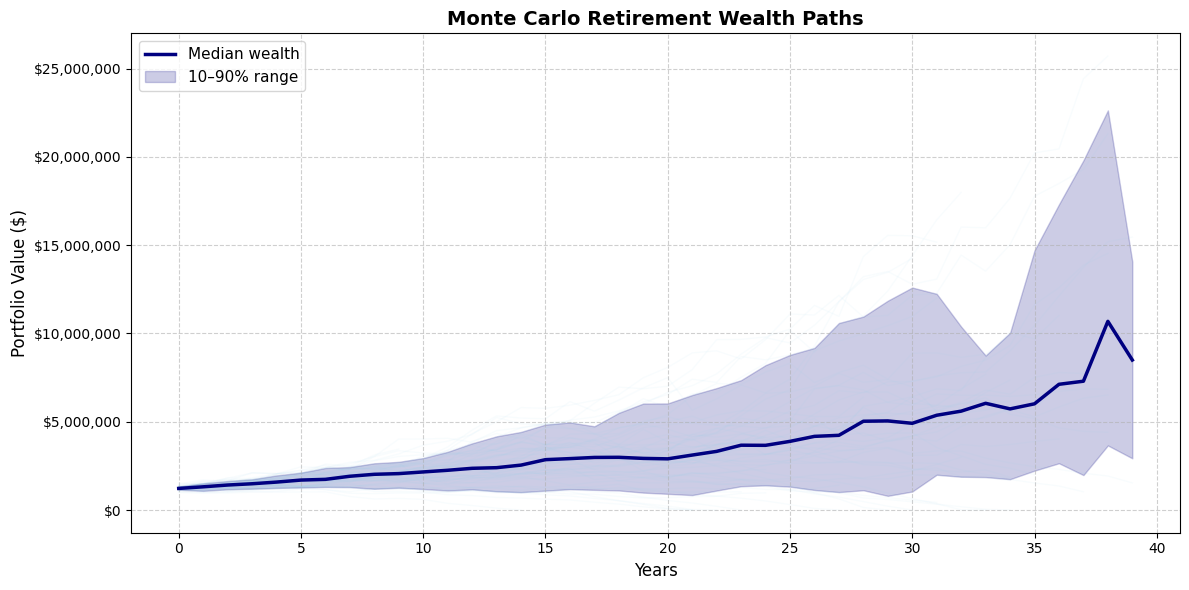

In [22]:
# Spaghetti plot
# Run the spaghetti plot with 50 Monte Carlo paths to visualize dispersion.
# This will:
#   - simulate 50 independent wealth paths,
#   - draw faint lines for each path,
#   - overlay the median path and the 10–90% percentile band.
spaghetti_plot(50)


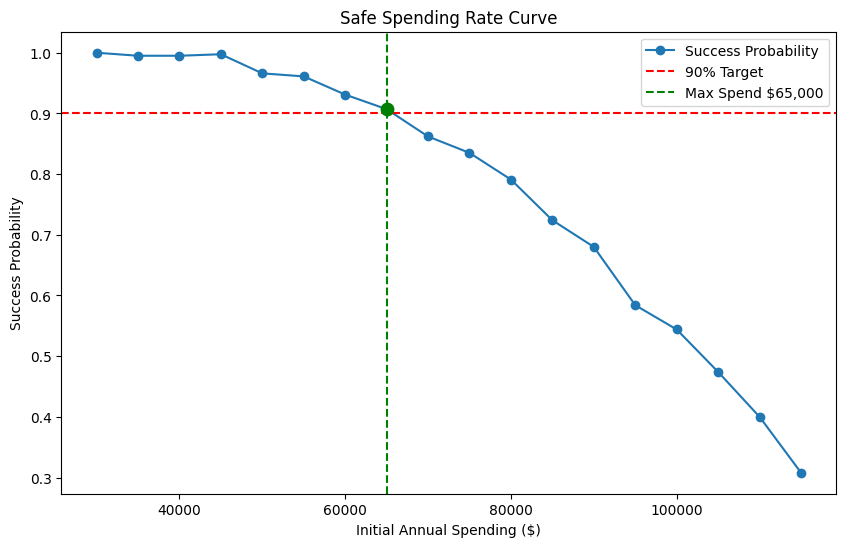

In [23]:
# ==============================================
# Safe Spending Rate Curve (Success Probability)
# ==============================================

# Define spending levels to test
spending_levels = np.arange(30000, 120000, 5000)

# Compute success probabilities for each spending level
rates = [_estimate_success(exp, trials=1000) for exp in spending_levels]

# Find max sustainable spending at 90% success
max_spend, max_rate = None, None
for exp, rate in zip(spending_levels, rates):
    if rate >= 0.90:
        max_spend, max_rate = exp, rate
    else:
        break  # stop once success rate falls below 90%

# Plot curve
plt.figure(figsize=(10,6))
plt.plot(spending_levels, rates, marker="o", label="Success Probability")

# Add 90% target line
plt.axhline(0.9, color="red", linestyle="--", label="90% Target")

# If max spending found, mark it
if max_spend:
    plt.axvline(max_spend, color="green", linestyle="--", label=f"Max Spend ${max_spend:,}")
    plt.scatter(max_spend, max_rate, color="green", s=80, zorder=5)

# Axis labels and title
plt.xlabel("Initial Annual Spending ($)")
plt.ylabel("Success Probability")
plt.title("Safe Spending Rate Curve")

# Add legend
plt.legend()

# Display plot
plt.show()


In [24]:
# ================================================================
# Detailed trace of a single Monte Carlo simulation path
# ================================================================

# Run one simulation path with full year-by-year details
df = simulate_with_trace()

# Print the last 25 years of the trace, focusing on key columns:
# - Year: calendar year of simulation
# - Expenses: annual spending (after inflation/spending rules)
# - Inflation: simulated inflation applied that year
# - Growth: portfolio return applied (allocation-weighted)
# - Portfolio_End: ending portfolio value for that year
print(df[["Year", "Expenses", "Inflation", "Growth", "Portfolio_End"]].tail(25))

# Save the full detailed trace to CSV for later analysis (Excel, etc.)
df.to_csv("detailed_trace.csv", index=False)

# Confirm to user that file was saved
print("Detailed trace saved to detailed_trace.csv")


    Year       Expenses  Inflation    Growth  Portfolio_End
1   2026   82927.677477   0.023349  0.085873   1.245937e+06
2   2027   84522.440505   0.019231  0.107315   1.343191e+06
3   2028   86403.105107   0.022250  0.060650   1.388240e+06
4   2029   86403.105107   0.000000  0.246711   1.686005e+06
5   2030   88982.302274   0.029851 -0.027309   1.604924e+06
6   2031   93424.927497   0.049927  0.010464   1.578284e+06
7   2032   96476.367698   0.032662  0.038926   1.609671e+06
8   2033  100301.421924   0.039648  0.191858   1.881092e+06
9   2034  103663.648789   0.033521  0.163752   2.148647e+06
10  2035  107859.548250   0.040476  0.078728   2.276139e+06
11  2036  112038.126390   0.038741  0.142227   2.551503e+06
12  2037  116039.488047   0.035714  0.094712   2.742081e+06
13  2038  119582.077573   0.030529  0.363362   3.669709e+06
14  2039  130383.039419   0.090323 -0.095373   3.267879e+06
15  2040  139426.949667   0.069364  0.000562   3.195163e+06
16  2041  110057.861873   0.052478  0.09

In [25]:
# ================================================================
# Death age sampling and horizon calculation test
# ================================================================

# Run multiple samples to see variability in death ages and horizon length
for _ in range(5):
    # Get horizon (# of simulation years) and sampled death ages
    # - Uses SSA mortality table if stochastic mortality is enabled
    # - Otherwise uses deterministic life expectancies
    years, death_A, death_B = get_horizon_and_deaths(2025)

    # Print results in a readable format
    # Sim years = length of simulation (max of A or B lifespan)
    # Death A/B = sampled death ages of each spouse
    print(f"Sim years: {years}, Death A: {death_A}, Death B: {death_B}")


Sim years: 39, Death A: 87, Death B: 99
Sim years: 23, Death A: 73, Death B: 83
Sim years: 29, Death A: 94, Death B: 74
Sim years: 20, Death A: 85, Death B: 77
Sim years: 40, Death A: 97, Death B: 100


In [26]:
# ================================================================
# Mean growth and inflation statistics from simulation trace
# ================================================================

# Calculate and display the average portfolio growth rate across all years
# - "Growth" column comes from simulate_with_trace(), representing annual portfolio return
print("Mean Growth:", trace_df["Growth"].mean())

# Calculate and display the average inflation rate across all years
# - "Inflation" column is either regime-driven or fixed COLA depending on params
print("Mean Inflation:", trace_df["Inflation"].mean())


Mean Growth: 0.08907573602941155
Mean Inflation: 0.031337897180430736


        count       mean        std  min  25%   50%    75%    max
Regime                                                           
high     14.0  17.571429  19.836696  1.0  3.0  10.0  24.75   70.0
low      37.0  18.594595  28.002440  1.0  2.0   7.0  22.00  112.0
mid      50.0   5.260000   5.816269  1.0  2.0   3.0   6.75   28.0


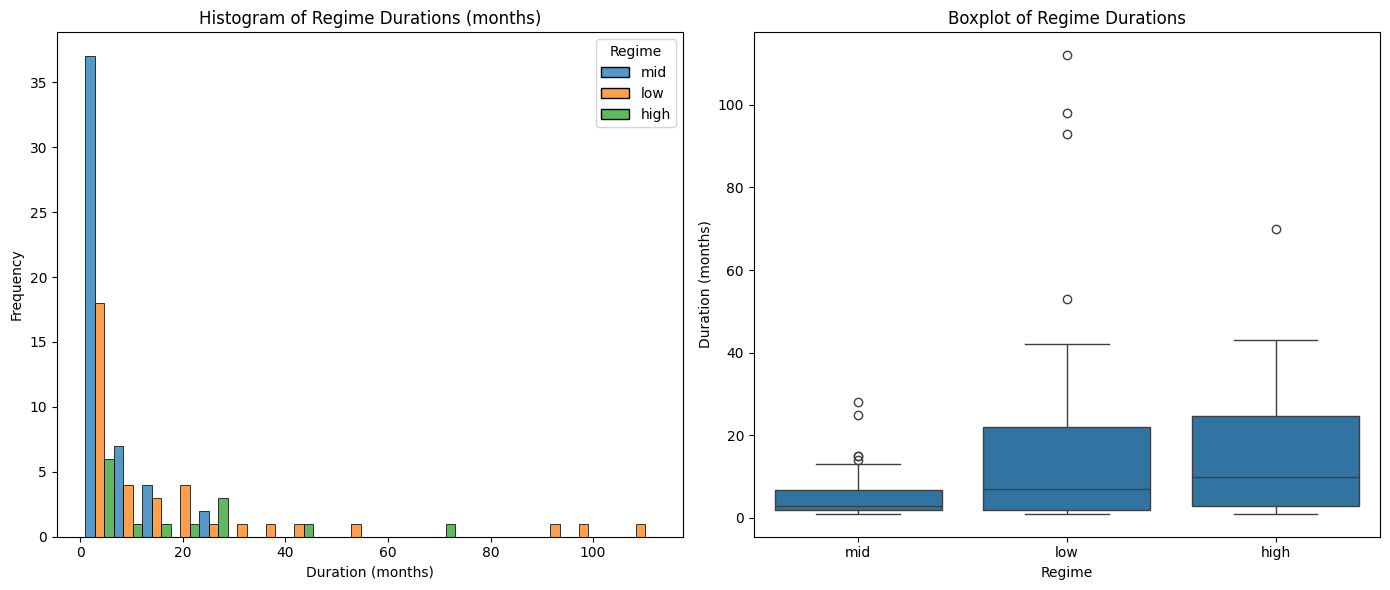

In [27]:
# =====================================================================
# Regime duration analysis (historical) using saved CSV
# =====================================================================

# Extract the regime column from the historical dataset
regimes = data["Regime"]

# ---------------------------------------------------------------
# Count consecutive runs of the same regime
# ---------------------------------------------------------------
durations = []
current = regimes.iloc[0]
count = 1

for r in regimes.iloc[1:]:
    if r == current:
        count += 1
    else:
        durations.append((current, count))
        current = r
        count = 1
durations.append((current, count))

# ---------------------------------------------------------------
# Convert run-length records into DataFrame for analysis
# ---------------------------------------------------------------
durations_df = pd.DataFrame(durations, columns=["Regime", "Length_months"])

# ---------------------------------------------------------------
# Summarize regime duration statistics
# ---------------------------------------------------------------
print(durations_df.groupby("Regime")["Length_months"].describe())

# ---------------------------------------------------------------
# Plot histograms of regime durations
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram by regime
sns.histplot(data=durations_df, x="Length_months", hue="Regime",
             multiple="dodge", bins=20, ax=axes[0])
axes[0].set_title("Histogram of Regime Durations (months)")
axes[0].set_xlabel("Duration (months)")
axes[0].set_ylabel("Frequency")

# Boxplot for visualizing spread and outliers
sns.boxplot(data=durations_df, x="Regime", y="Length_months", ax=axes[1])
axes[1].set_title("Boxplot of Regime Durations")
axes[1].set_xlabel("Regime")
axes[1].set_ylabel("Duration (months)")

plt.tight_layout()
plt.show()


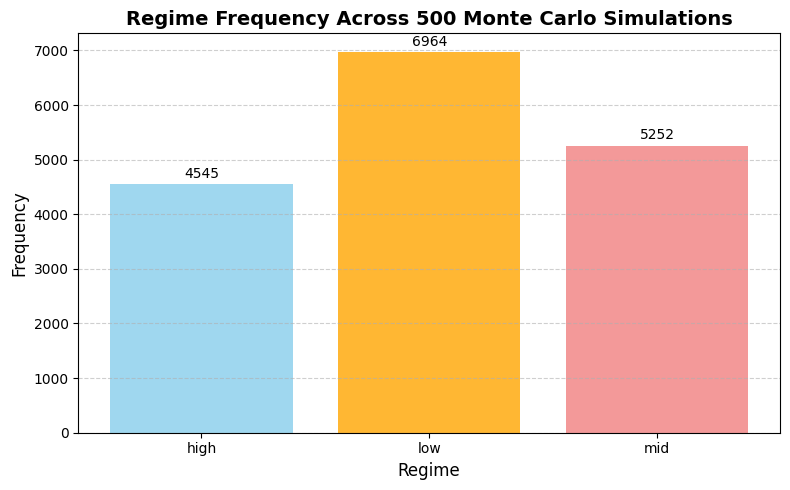

Counter({'low': 6964, 'mid': 5252, 'high': 4545})


In [28]:
# =====================================================================
# Regime path frequency analysis with visualization
# =====================================================================
from collections import Counter

# Counter to accumulate how many times each regime is observed
counts = Counter()

# Run 500 Monte Carlo simulation paths and record regimes
for _ in range(500):
    # simulate_once(..., return_regimes=True) returns (end_val, hist, regime_path)
    _, _, regimes = simulate_once(return_regimes=True)
    counts.update(regimes)   # add regime occurrences into the counter

# Convert results to DataFrame for plotting
regime_freq = pd.DataFrame.from_dict(counts, orient="index", columns=["Count"])
regime_freq = regime_freq.sort_index()

# Bar plot of regime frequencies
plt.figure(figsize=(8,5))
plt.bar(regime_freq.index, regime_freq["Count"], color=["skyblue","orange","lightcoral"], alpha=0.8)
plt.title("Regime Frequency Across 500 Monte Carlo Simulations", fontsize=14, fontweight="bold")
plt.xlabel("Regime", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add value labels on top of bars
for i, v in enumerate(regime_freq["Count"]):
    plt.text(i, v + max(regime_freq["Count"])*0.01, str(v), ha="center", va="bottom", fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Print raw frequency counts for reference
print(counts)



=== Historical Regime Duration Stats (months) ===
        count       mean        std  min  median  max
Regime                                               
high       14  17.571429  19.836696    1    10.0   70
low        37  18.594595  28.002440    1     7.0  112
mid        50   5.260000   5.816269    1     3.0   28

=== Historical Regime Frequency (share of months) ===
        Hist_Freq
Regime           
high     0.205514
low      0.574770
mid      0.219716

=== Simulated Regime Duration Stats (months) ===
        count      mean       std  min  median  max
Regime                                             
high     1740  5.550000  4.866159    1     4.0   31
low      2398  5.830692  5.054367    1     4.0   38
mid      2341  4.340453  3.661982    1     3.0   29

=== Simulated Regime Frequency (share of simulated years) ===
      Sim_Freq
high  0.285710
low   0.413669
mid   0.300621

=== Regime Frequency: Historical vs Simulated ===
      Hist_Freq  Sim_Freq  Diff (Sim - Hist)
high 

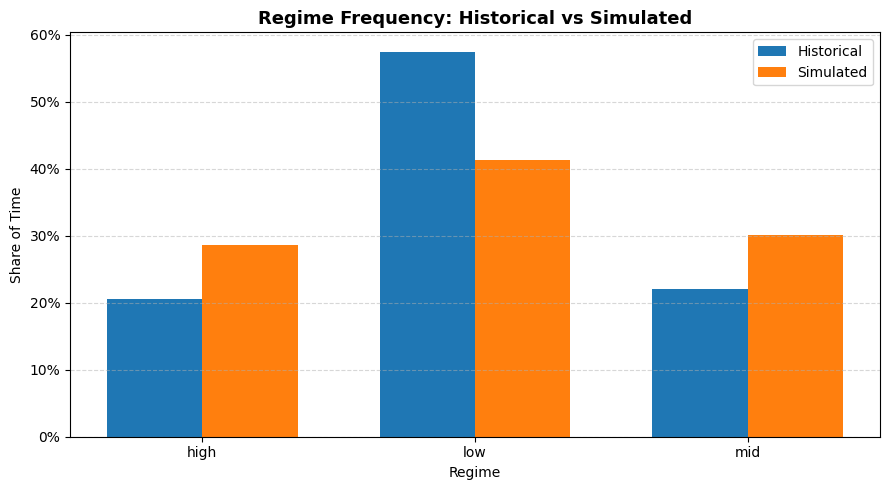

In [29]:
# =====================================================================
# Historical vs Simulated Regime Analysis (side-by-side)
# - Part A: Historical regime durations & frequencies from `data["Regime"]`
# - Part B: Monte Carlo simulated regime frequencies & run-lengths
# - Part C: Side-by-side comparison table + bar chart
# =====================================================================

from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Part A — Historical (from data)
# -------------------------------

# 1) Historical regime labels (already computed earlier in your pipeline)
hist_regimes = data["Regime"]

# 2) Historical run-lengths (consecutive months in the same regime)
hist_durations = []
cur = hist_regimes.iloc[0]
count = 1
for r in hist_regimes.iloc[1:]:
    if r == cur:
        count += 1
    else:
        hist_durations.append((cur, count))
        cur, count = r, 1
hist_durations.append((cur, count))  # final run

hist_durations_df = pd.DataFrame(hist_durations, columns=["Regime", "Length_months"])

# 3) Historical frequency (share of months spent in each regime)
hist_freq = hist_regimes.value_counts(normalize=True).rename("Hist_Freq").sort_index()

# 4) Historical duration stats (by regime)
hist_duration_stats = (
    hist_durations_df.groupby("Regime")["Length_months"]
    .agg(["count", "mean", "std", "min", "median", "max"])
    .sort_index()
)

print("\n=== Historical Regime Duration Stats (months) ===")
print(hist_duration_stats)

print("\n=== Historical Regime Frequency (share of months) ===")
print(hist_freq.to_frame())


# -----------------------------------------
# Part B — Simulated (from regime path MC)
# -----------------------------------------

N_PATHS = 1000  # number of Monte Carlo paths to simulate
sim_counts = Counter()         # regime occurrence counts across all years and paths
sim_run_lengths = defaultdict(list)  # store run-lengths per regime (to summarize durations)

for _ in range(N_PATHS):
    # simulate_once(..., return_regimes=True) → (end_val, port_hist, regime_path)
    _, _, path = simulate_once(return_regimes=True)

    # Count regime occurrences
    sim_counts.update(path)

    # Compute run-lengths along this simulated path
    cur = path[0]
    cnt = 1
    for r in path[1:]:
        if r == cur:
            cnt += 1
        else:
            sim_run_lengths[cur].append(cnt)
            cur, cnt = r, 1
    sim_run_lengths[cur].append(cnt)

# 1) Simulated frequency (share of simulated years spent in each regime)
total_sim_obs = sum(sim_counts.values())
sim_freq = pd.Series({k: v / total_sim_obs for k, v in sim_counts.items()}, name="Sim_Freq").sort_index()

# 2) Simulated duration stats (per regime)
sim_duration_stats = (
    pd.DataFrame({
        "Regime": list(sim_run_lengths.keys()),
        "Length_months_list": list(sim_run_lengths.values())
    })
    .explode("Length_months_list")
    .rename(columns={"Length_months_list": "Length_months"})
)
sim_duration_stats["Length_months"] = sim_duration_stats["Length_months"].astype(int)

sim_duration_summary = (
    sim_duration_stats.groupby("Regime")["Length_months"]
    .agg(["count", "mean", "std", "min", "median", "max"])
    .sort_index()
)

print("\n=== Simulated Regime Duration Stats (months) ===")
print(sim_duration_summary)

print("\n=== Simulated Regime Frequency (share of simulated years) ===")
print(sim_freq.to_frame())


# ----------------------------------------------------
# Part C — Side-by-side comparison table + bar chart
# ----------------------------------------------------

# Merge historical vs simulated frequencies
freq_compare = pd.concat([hist_freq, sim_freq], axis=1).fillna(0.0)
freq_compare["Diff (Sim - Hist)"] = freq_compare["Sim_Freq"] - freq_compare["Hist_Freq"]

print("\n=== Regime Frequency: Historical vs Simulated ===")
print(freq_compare)

# Optional: merge duration means to compare persistence
duration_compare = pd.concat(
    [
        hist_duration_stats["mean"].rename("Hist_Mean_Duration"),
        sim_duration_summary["mean"].rename("Sim_Mean_Duration")
    ],
    axis=1
).sort_index()
duration_compare["Diff (Sim - Hist)"] = duration_compare["Sim_Mean_Duration"] - duration_compare["Hist_Mean_Duration"]

print("\n=== Mean Regime Duration (months): Historical vs Simulated ===")
print(duration_compare)

# ---- Bar chart comparing Historical vs Simulated regime frequency ----
fig, ax = plt.subplots(figsize=(9, 5))

regime_labels = freq_compare.index.tolist()
x = np.arange(len(regime_labels))
width = 0.35  # bar width

ax.bar(x - width/2, freq_compare["Hist_Freq"].values, width, label="Historical")
ax.bar(x + width/2, freq_compare["Sim_Freq"].values,  width, label="Simulated")

ax.set_title("Regime Frequency: Historical vs Simulated", fontsize=13, fontweight="bold")
ax.set_xlabel("Regime")
ax.set_ylabel("Share of Time")
ax.set_xticks(x)
ax.set_xticklabels(regime_labels)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0%}"))

ax.grid(True, linestyle="--", alpha=0.5, axis="y")
ax.legend()

plt.tight_layout()
plt.show()


In [30]:
# =========================================
# Max safe initial spending test
# =========================================

# Run the binary search with early-stopping success estimator
max_spend, success = max_initial_spending(
    target_success=0.90,   # 90% success target
    return_rate=True       # return both spend and success rate
)

# Show result
print("Max safe spend:", max_spend, "Success rate:", round(success, 3))


Max safe spend: 66406 Success rate: 0.898


In [31]:
# =========================================
# Optimize guardrails + verbal interpretation
# =========================================

# Run guardrail optimization targeting 90% success probability
cfg, spend, rate = optimize_guardrails(target_success=0.90)

# -----------------------------
# Verbal interpretation helpers
# -----------------------------
def _fmt_currency(x): 
    return f"${x:,.0f}"

def _fmt_pct(x): 
    return f"{100*x:.1f}%"

# Recreate the confirmation trial size used in optimize_guardrails() Stage 2
# (used to print a Wilson ~95% CI for the success rate)
n_confirm = 800  # must match `confirm_trials2` in optimize_guardrails
lo_ci, hi_ci = _wilson_ci(int(round(rate * n_confirm)), n_confirm, z=1.96)

# Compute implied initial withdrawal rate vs current portfolio size
starting_portfolio = (
    params["taxable_init"] + params["td_A_init"] + 
    params["td_B_init"] + params["roth_init"]
)
implied_wr = spend / starting_portfolio if starting_portfolio > 0 else np.nan

# --------------------------------
# Print results + interpretation
# --------------------------------
print("=== Guardrails Optimization Result ===")
print(f"Best guardrail config: {cfg}")
print(f"Max safe initial spending (≥90% target): {_fmt_currency(spend)}")
print(f"Confirmed success rate: {_fmt_pct(rate)} "
      f"(~95% CI: {_fmt_pct(lo_ci)} – {_fmt_pct(hi_ci)}; n={n_confirm})")
print(f"Implied initial withdrawal rate: {_fmt_pct(implied_wr)} of starting portfolio "
      f"({_fmt_currency(starting_portfolio)})")

# Explain what the chosen guardrails mean in practice
if cfg is not None:
    lg = cfg.get("lower_guardrail")
    ug = cfg.get("upper_guardrail")
    cf = cfg.get("cut_factor")
    rf = cfg.get("raise_factor")
    print("\nInterpretation:")
    print(f"- Spending starts at {_fmt_currency(spend)} and adjusts with your rule:")
    print(f"  • If the *current* withdrawal rate drops below {100*lg:.1f}%, spending increases by {100*rf:.0f}%.")
    print(f"  • If the *current* withdrawal rate rises above {100*ug:.1f}%, spending is cut by {100*cf:.0f}%.")
    print("  • Between the guardrails, spending simply follows your inflation/SS/pension dynamics.")
    print("- The success probability reflects Monte Carlo paths with your return model, inflation regimes, taxes,")
    print("  RMDs, mortality logic, and withdrawal sequence. The CI shows statistical uncertainty from simulation.")
else:
    print("\nInterpretation:")
    print("- No feasible guardrail configuration met the 90% target in the screened grid.")
    print("  Consider widening the parameter grid, adjusting allocation, or revisiting spending assumptions.")


=== Guardrails Optimization Result ===
Best guardrail config: {'cut_factor': 0.05, 'raise_factor': 0.05, 'lower_guardrail': 0.03, 'upper_guardrail': 0.055}
Max safe initial spending (≥90% target): $135,799
Confirmed success rate: 90.4% (~95% CI: 88.1% – 92.2%; n=800)
Implied initial withdrawal rate: 11.3% of starting portfolio ($1,200,000)

Interpretation:
- Spending starts at $135,799 and adjusts with your rule:
  • If the *current* withdrawal rate drops below 3.0%, spending increases by 5%.
  • If the *current* withdrawal rate rises above 5.5%, spending is cut by 5%.
  • Between the guardrails, spending simply follows your inflation/SS/pension dynamics.
- The success probability reflects Monte Carlo paths with your return model, inflation regimes, taxes,
  RMDs, mortality logic, and withdrawal sequence. The CI shows statistical uncertainty from simulation.
